# Task

Implement RealNVP model and train it on mnist datasets.

- Build the RealNVP architecture (you could extend from lecture example) for grayscale MNIST Digits and MNIST Fashion images
- Use Coupling Layer and Multi-Scale
- Implement train loop with validation metrics, evaluate on test set
- Train the model until it achieves reasonable likelihood and visualize generated samples by inverting the flow.
- Experiments with hyperparameters or architecture to get nice results of generation. You should try to get somewhat reasonable generation quality for generation.

# Disclaimer

Most of the decisions and individual additions in this code (such as the transition from `ConvSTNet` to `GatedConvNet`) were inspired in one way or another by the following works:
1. [Normalizing Flows for image modeling](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html) by Phillip Lippe as part of the [UVA Deep Learning Course](https://uvadlc.github.io/)
2. [Production ready implementation](https://github.com/shirleyzhu233/realNVP/tree/master) by some Asians (as always)
3. [Another implementation with a lot of self-reflection](https://github.com/bjlkeng/sandbox/blob/master/realnvp/pytorch-realnvp-mnist.ipynb) by another Asian
4. And from the paper too. I swear, I've read it and the improved versions like Flow++, but the implementation of things like masking convolutions is missing here.

## Imports

In [ ]:
import copy
import math

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.distributions import Normal
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## Data Preparing

Both MNIST datasets have [1, 28, 28] image shape, because of the grayscale.

So basically, we will start with checkerboard affine coupling and adding the channelwise variation can be avoided, but preferable after the squeeze operation for mixing across the 4 sub-pixel channels in each coarse location.

The other discussion is about the need of dequantization of the original images, because of the initially discrete values of pixels, that can lead to undesired density models where arbitrarily high likelihood are placed on a few, particular values.

But let's start simple

In [ ]:
def get_mnist_loaders(dataset: str = "mnist", data_root: str = "./data", batch_size: int = 128, val_split: float = 0.1):
  if dataset == "mnist":
      DatasetClass = datasets.MNIST
  else:
      DatasetClass = datasets.FashionMNIST

  transform = transforms.ToTensor() # normalization uint8 [0,255] to float [0,1]

  full_train = DatasetClass(
      root=data_root,
      train=True,
      download=True,
      transform=transform)

  test_ds = DatasetClass(
      root=data_root,
      train=False,
      download=True,
      transform=transform)

  n_total = len(full_train)
  n_val = int(n_total * val_split)
  n_train = n_total - n_val

  print(f"\n--- {dataset.upper()} DATASET ---")
  print(f"Total train images: {n_total}")
  print(f"  Train split:      {n_train}")
  print(f"  Validation split: {n_val}")
  print(f"Test set size:      {len(test_ds)}\n")

  train_ds, val_ds = random_split(
      full_train,
      [n_train, n_val],
      generator=torch.Generator().manual_seed(42))

  train_loader = DataLoader(
      train_ds,
      batch_size=batch_size,
      shuffle=True)

  val_loader = DataLoader(
      val_ds,
      batch_size=batch_size,
      shuffle=False)

  test_loader = DataLoader(
      test_ds,
      batch_size=batch_size,
      shuffle=False)

  return train_loader, val_loader, test_loader

def show_samples(loader, title: str):
  x, y = next(iter(loader))
  x = x[:4]
  y = y[:4]

  fig, axes = plt.subplots(1, 4, figsize=(8, 2))
  fig.suptitle(title)

  for i in range(4):
    img = x[i].squeeze(0)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"label: {y[i].item()}")
    axes[i].axis("off")

  plt.tight_layout()
  plt.show()

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]



--- MNIST DATASET ---
Total train images: 60000
  Train split:      54000
  Validation split: 6000
Test set size:      10000



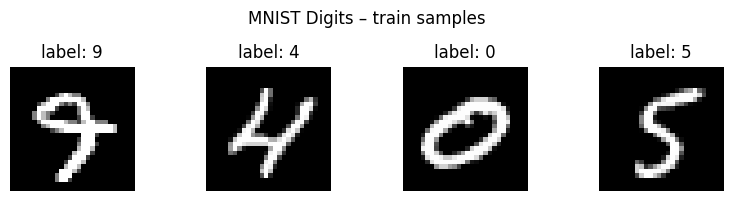

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.59MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.62MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.4MB/s]



--- FASHION DATASET ---
Total train images: 60000
  Train split:      54000
  Validation split: 6000
Test set size:      10000



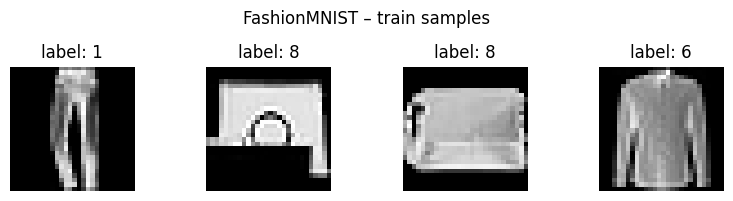

In [ ]:
train_digits, val_digits, test_digits = get_mnist_loaders(
    dataset="mnist",
    batch_size=128)
show_samples(train_digits, "MNIST Digits – train samples")

train_fashion, val_fashion, test_fashion = get_mnist_loaders(
    dataset="fashion",
    batch_size=128)
show_samples(train_fashion, "FashionMNIST – train samples")

## Coupling Layer

The implementation contains:
* Affine coupling
- Three choices `Net` to predict (s) and (t) from the masked input.
- A single learnable scaling factor for (s) (not per channel).  
  For MNIST (grayscale; C=1 before squeeze, C=4 after) this is sufficient to stabilize `exp(s)` without overcomplicating the model.
- Two mask types:
  - Checkerboard over spatial positions
  - Channelwise over channels after squeeze when C>1
- A `flip` flag to swap context and transformed parts between layers so that, across several couplings, every pixel/channel is transformed at least sometimes.

### General Math

Given a binary mask $m \in \{0,1\}^{B \times C \times H \times W}$

Context part: $x_{\text{ctx}} = m \odot x$

A CNN predicts log-scale $s$ and shift $t$: $(s, t) = \text{Net}(x_{\text{ctx}})$

We only transform the unmasked entries:
  $$
  s' = (1 - m) \odot s,\qquad
  t' = (1 - m) \odot t
  $$

Forward (data → latent): $y = x \odot e^{s'} + t'$

Inverse (latent → data): $x = (y - t') \odot e^{-s'}$

Log-det of Jacobian for one sample: $\log|\det J| = \sum_{c,h,w} s'_{b,c,h,w}$

### `Net` Variations
* `ConvSTNet` (baseline): 3-layer CNN (Conv-ReLU-Conv-ReLU-Conv) that outputs $2C$ channels and splits into $s,t$. Fast, simple, cheap, usually underfits and becomes harder to optimize when we increase depth/width because of limited depth and inductive bias.

* `BottleneckConvSTNet`: wider features + a few residual blocks (with normalization) before projecting to $2C$. More capacity, residual blocks make optimization easier for deeper ST networks, InstanceNorm helps keep activations in a reasonable range.

* `GatedSTWrapper`: wraps a gated ResNet-style conv net (`GatedConvNet`) with normalization and gated updates $x + \text{val}\cdot\sigma(\text{gate})$. Benefits from symmetric nonlinearity and stronger gradients for negative values. Normalizes across channels per spatial location and can selectively apply changes.


**Stability note:** in the stronger nets the last conv is zero-initialized, so initially $s\approx 0, t\approx 0$ and the coupling starts near identity (helps prevent $e^s$ blow-ups). The other option was to include a global learnable scale for $s$ (one scalar, not per-channel) to control the magnitude before the exponential, but might be just over-parameterizing with the given data.



### Internal CNNs

In [ ]:
class ConvSTNet(nn.Module):
  """
  Small CNN that predicts [s, t] from the masked input.
  Input: x_masked  ∈ ℝ^{B×C×H×W}
  Output: tensor of shape B×(2C)×H×W, split into (s, t).
  """
  def __init__(self, c_in, hidden_channels=32):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(c_in, hidden_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, 2 * c_in, kernel_size=3, padding=1))

  def forward(self, x):
    out = self.net(x)
    s, t = out.chunk(2, dim=1)
    return s, t

In [ ]:
class STResidualBlock(nn.Module):
  """
  Simple residual block for the s,t network:
  Conv -> ReLU -> Conv + skip
  Keeps spatial size and channel count.
  """
  def __init__(self, c_in):
    super().__init__()
    self.conv1 = nn.Conv2d(c_in, c_in, kernel_size=3, padding=1)
    self.norm1 = nn.InstanceNorm2d(c_in, affine=True)
    self.conv2 = nn.Conv2d(c_in, c_in, kernel_size=3, padding=1)
    self.norm2 = nn.InstanceNorm2d(c_in, affine=True)
    self.act = nn.ReLU(inplace=True)

  def forward(self, x):
    identity = x
    out = self.act(self.norm1(self.conv1(x)))
    out = self.norm2(self.conv2(out))
    out = out + identity
    out = self.act(out)
    return out

class BottleneckConvSTNet(nn.Module):
  """
  Stronger CNN to predict [s, t] from masked input.

  Input: x_masked {B×C×H×W}
  Output: s, t with shape B×C×H×W each.
  """
  def __init__(self, c_in, hidden_channels=64, n_blocks=3):
    super().__init__()

    # lift to hidden width
    self.in_conv = nn.Conv2d(c_in, hidden_channels, kernel_size=3, padding=1)
    self.in_norm = nn.InstanceNorm2d(hidden_channels, affine=True)
    self.in_act = nn.ReLU(inplace=True)

    # residual body
    blocks = []
    for _ in range(n_blocks):
        blocks.append(STResidualBlock(hidden_channels))
    self.blocks = nn.Sequential(*blocks)

    # project back to 2 * c_in (for s and t)
    self.out_conv = nn.Conv2d(hidden_channels, 2 * c_in, kernel_size=3, padding=1)

    # last layer initialized to zero
    nn.init.zeros_(self.out_conv.weight)
    nn.init.zeros_(self.out_conv.bias)

  def forward(self, x):
    """
    x: [B, C, H, W] masked input
    returns: s, t each [B, C, H, W]
    """
    h = self.in_act(self.in_norm(self.in_conv(x)))
    h = self.blocks(h)
    out = self.out_conv(h)
    s, t = out.chunk(2, dim=1)
    return s, t

**Note:** Everything except the wrapper is taken entirely from the first link in the disclaimer, and the variant itself was originally inspired by the Flow++ implementation.

In [ ]:
class ConcatELU(nn.Module):
  """
  Activation function that applies ELU in both direction (inverted and plain).
  Allows non-linearity while providing strong gradients for any input (important for final convolution)
  """

  def forward(self, x):
    return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):
  def __init__(self, c_in, eps=1e-5):
    """
    This module applies layer norm across channels in an image.
    Inputs:
        c_in - Number of channels of the input
        eps - Small constant to stabilize std
    """
    super().__init__()
    self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
    self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(dim=1, keepdim=True)
    var = x.var(dim=1, unbiased=False, keepdim=True)
    y = (x - mean) / torch.sqrt(var + self.eps)
    y = y * self.gamma + self.beta
    return y


class GatedConv(nn.Module):
  def __init__(self, c_in, c_hidden):
    """
    This module applies a two-layer convolutional ResNet block with input gate
    Inputs:
        c_in - Number of channels of the input
        c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
    """
    super().__init__()
    self.net = nn.Sequential(
        ConcatELU(),
        nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
        ConcatELU(),
        nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1))

  def forward(self, x):
    out = self.net(x)
    val, gate = out.chunk(2, dim=1)
    return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):
  def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
    """
    Module that summarizes the previous blocks to a full convolutional neural network.
    Inputs:
        c_in - Number of input channels
        c_hidden - Number of hidden dimensions to use within the network
        c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
        num_layers - Number of gated ResNet blocks to apply
    """
    super().__init__()
    c_out = c_out if c_out > 0 else 2 * c_in
    layers = []
    layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
    for layer_index in range(num_layers):
        layers += [GatedConv(c_hidden, c_hidden),
                    LayerNormChannels(c_hidden)]
    layers += [ConcatELU(),
                nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
    self.nn = nn.Sequential(*layers)

    self.nn[-1].weight.data.zero_()
    self.nn[-1].bias.data.zero_()

  def forward(self, x):
    return self.nn(x)


class GatedSTWrapper(nn.Module):
  """Wraps GatedConvNet so that it returns (s, t) instead of a single tensor."""
  def __init__(self, c_in, hidden_channels=32, num_layers=3):
    super().__init__()
    self.core = GatedConvNet(c_in=c_in, c_hidden=hidden_channels,
                              c_out=2*c_in, num_layers=num_layers)

  def forward(self, x):
    out = self.core(x) # [B, 2C, H, W]
    s, t = out.chunk(2, dim=1)
    return s, t

### Main Layer

In [ ]:
class CouplingLayer(nn.Module):
  """
  Generic affine coupling layer for images, where s, t and m is either:
    - checkerboard mask over (H, W)
    - channelwise mask over channels

  Input:
    c_in: number of input channels (C)
    hidden: number of hidden channels in ConvSTNet
    mask_type: "checkerboard" or "channelwise"
    flip: swap which part is context vs transformed
    st_net: optional nn.Module that maps x_ctx -> (s, t).
                   If None, uses ConvSTNet(c_in, hidden).
  """
  def __init__(self, c_in, hidden=32, mask_type="checkerboard", flip=False, st_net: nn.Module = None,):
    super().__init__()
    assert mask_type in ("checkerboard", "channelwise")
    self.c_in = c_in
    self.hidden = hidden
    self.mask_type = mask_type
    self.flip = flip

    if st_net is None:
      self.st_net = ConvSTNet(c_in, hidden)
    else:
      self.st_net = st_net

    # Learnable single scalar to control scale magnitude (I'm lazy to do this per-channel too but could)
    self.log_s_factor = nn.Parameter(torch.zeros(1))

  def _build_mask(self, x):
    B, C, H, W = x.shape
    device = x.device

    if self.mask_type == "checkerboard":
      i = torch.arange(H, device=device).view(-1, 1)
      j = torch.arange(W, device=device).view(1, -1)
      checker = (i + j) % 2
      if self.flip:
          checker = 1 - checker
      m = checker.view(1, 1, H, W).float().expand(B, C, H, W)

    else:  # channelwise
      assert C >= 2, "Channelwise mask needs at least 2 channels"
      m = torch.ones(1, C, 1, 1, device=device)
      half = C // 2
      if not self.flip:
        # [0:half] context
        m[:, half:, :, :] = 0.
      else:
        # [0:half] transformed
        m[:, :half, :, :] = 0.

      m = m.expand(B, C, H, W)

    return m

  def forward(self, x, ldj=None, reverse=False):
    """
    Forward or inverse pass through coupling layer.

    Input:
      x: tensor of shape [B, C, H, W]
      ldj: log-det-Jacobian accumulator (shape [B]), or None
      reverse: False (x→y), True (y→x)

    Output:
      y: transformed tensor, same shape as x
      ldj: updated log-det-Jacobian per sample
    """
    if ldj is None:
      # One scalar ldj per element in batch
      ldj = x.new_zeros(x.size(0))

    B, C, H, W = x.shape
    m = self._build_mask(x) # mask
    x_ctx = x * m # context
    s, t = self.st_net(x_ctx)  # predict [s, t] from context

    # stabilize s (log-scale)
    s_factor = self.log_s_factor.exp().view(1, 1, 1, 1)
    s = torch.tanh(s / (s_factor + 1e-6)) * s_factor

    # zero out s, t on the masked positions
    s = s * (1.0 - m)
    t = t * (1.0 - m)

    if not reverse:
      y = x * torch.exp(s) + t
      ldj = ldj + s.view(B, -1).sum(dim=1) # sum of s over transformed dims
    else:
      y = (x - t) * torch.exp(-s)
      ldj = ldj - s.view(B, -1).sum(dim=1)

    return y, ldj

## Multi-scale Additions

**SqueezeFlow**  
  Reshapes the image $B, C, H, W] \;\longrightarrow\; [B, 4C, H/2, W/2]$ by packing each 2x2 spatial block into the channel dimension.  
  This is a pure permutation/reshape, so the log-det-Jacobian does not change (`ldj` is passed through unchanged).

**SplitFlow**  
  Splits channels in half $z = [z_1, z_2]$ along channels and factors out $z_2$:
  - In the forward direction, we keep only $z_1$ for deeper layers and add $log p(z_2)$ with a standard normal prior to `ldj`.
  - In the reverse direction, we sample $z_2 \sim N(0, I)$ concatenate it back, and subtract $\log p(z_2)$ from `ldj`.


In [ ]:
class SqueezeFlow(nn.Module):
  def forward(self, z, ldj, reverse=False):
    B, C, H, W = z.shape
    if not reverse:
      z = z.reshape(B, C, H//2, 2, W//2, 2)
      z = z.permute(0, 1, 3, 5, 2, 4)
      z = z.reshape(B, 4*C, H//2, W//2)
    else:
      z = z.reshape(B, C//4, 2, 2, H, W)
      z = z.permute(0, 1, 4, 2, 5, 3)
      z = z.reshape(B, C//4, H*2, W*2)
    return z, ldj

class SplitFlow(nn.Module):
    def __init__(self):
      super().__init__()
      self.prior = Normal(loc=0.0, scale=1.0)

    def forward(self, z, ldj, reverse=False):
      if not reverse:
        z, z_split = z.chunk(2, dim=1)
        ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
      else:
        z_split = self.prior.sample(z.shape).to(z.device)
        z = torch.cat([z, z_split], dim=1)
        ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
      return z, ldj

## Normalization Layer

Deterministic and fully-invertible ActNorm is chosen because custom BatchNorm with tracked running stats seems to be overkill here.

For each channel $c$, ActNorm applies an affine transform $y_{c,h,w} = (x_{c,h,w} + b_c)\, \exp(s_c)$, where $b_c$ is a bias and $s_c$ is a log-scale. The same $b_c$ and $s_c$ are used for all spatial positions $(h,w)$ within that channel.

On the first batch, the layer initializes $b_c, s_c$ from data so that:
$$
\mathbb{E}[y_{c,\cdot,\cdot}] \approx 0,\quad \text{Var}(y_{c,\cdot,\cdot}) \approx 1
$$

After this data-dependent initialization, $b_c$ and $s_c$ are treated as ordinary learnable parameters and are no longer recomputed from the batch (unlike BatchNorm).

Because the transform is affine and per-channel, the Jacobian is diagonal in the spatial dimensions, and its log-determinant for one sample $x \in \mathbb{R}^{C\times H\times W}$ is easy:

  $$
  \log\left|\det \frac{\partial y}{\partial x}\right|
  = \sum_{c,h,w} s_c
  = (H \cdot W)\,\sum_{c} s_c
  $$

During training we add this log-det to the `ldj` accumulator, just like for coupling layers.


In [ ]:
class ActNorm2d(nn.Module):
  """
  Simple per-channel scale + bias.
  Initialized from first batch to have zero mean and unit variance.
  Contributes log-det to ldj.
  """
  def __init__(self, num_channels, eps=1e-6):
    super().__init__()
    self.num_channels = num_channels
    self.eps = eps
    self.initialized = False

    self.bias = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
    self.log_scale = nn.Parameter(torch.zeros(1, num_channels, 1, 1))

  def _init_from_data(self, x):
    with torch.no_grad():
      mean = x.mean(dim=[0, 2, 3], keepdim=True)
      var  = x.var(dim=[0, 2, 3], unbiased=False, keepdim=True)
      std  = torch.sqrt(var + self.eps)

      self.bias.data.copy_(-mean)
      self.log_scale.data.copy_(-torch.log(std))

    self.initialized = True

  def forward(self, x, ldj, reverse=False):
    if not self.initialized and self.training:
      self._init_from_data(x)

    if not reverse:
      # y = (x + bias) * exp(log_scale)
      x = (x + self.bias) * torch.exp(self.log_scale)
      # log-det: sum over spatial dims * sum over channels
      ldj = ldj + (self.log_scale * torch.ones_like(x)).view(x.size(0), -1).sum(dim=1)
    else:
      # inverse
      x = x * torch.exp(-self.log_scale) - self.bias
      ldj = ldj - (self.log_scale * torch.ones_like(x)).view(x.size(0), -1).sum(dim=1)

    return x, ldj

## Main Class

In [ ]:
class RealNVPMNIST(nn.Module):
  def __init__(self, flows):
    super().__init__()

    self.flows = nn.ModuleList(flows)
    self.prior = Normal(loc=0.0, scale=1.0)

  # f: X -> Z
  def f(self, x):
    """
    Forward through all flows: x -> z, accumulate ldj
    """
    z = x
    ldj = z.new_zeros(z.size(0))   # one ldj per batch element
    for flow in self.flows:
        z, ldj = flow(z, ldj, reverse=False)
    return z, ldj

  # g: Z -> X (sampling)
  def g(self, z):
    """
    Inverse through flows: z -> x
    """
    ldj = z.new_zeros(z.size(0))
    for flow in reversed(self.flows):
      z, ldj = flow(z, ldj, reverse=True)
    return z

  def forward(self, x, reverse=False):
    if not reverse:
      return self.f(x)
    else:
      return self.g(x)

  def log_prob(self, x):
    """
    log p(x) = log p(z) + ldj
    """
    z, ldj = self.f(x)
    log_pz = self.prior.log_prob(z).sum(dim=[1, 2, 3])
    return log_pz + ldj

## Train

In [ ]:
def train_realnvp(model, train_loader, device, n_epochs=30, lr=1e-3, log_interval=100, use_dequant=False):
  """
  Train RealNVPMNIST with NLL = -(log p(z) + log|det J|).

  Returns a dict with history of:
    - 'loss': epoch NLL per image
    - 'loss_per_pixel': epoch NLL per pixel
    - 'log_pz_mean': mean log p(z) per epoch
    - 'ldj_mean': mean log|det J| per epoch
    - 'log_px_mean': mean log p(x) per epoch
  """
  prior_z = Normal(loc=0.0, scale=1.0)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  max_grad_norm = 5.0

  history = {
      "loss": [],
      "loss_per_pixel": [],
      "log_pz_mean": [],
      "ldj_mean": [],
      "log_px_mean": []}

  H = W = 28
  D = H * W

  for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    total_batches = 0

    epoch_log_pz = 0.0
    epoch_ldj = 0.0
    epoch_log_px = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):
      x = x.to(device)  # [B,1,28,28] in [0,1]

      # optional simple dequantization
      if use_dequant:
        x = x + torch.rand_like(x) / 256.0
        x = x.clamp(0.0, 1.0)

      optimizer.zero_grad()

      # flow: x -> z, get log-det-J per sample
      z, ldj = model(x)

      # log p(z) under prior
      log_pz = prior_z.log_prob(z).sum(dim=[1, 2, 3])

      # log p(x) via change-of-variables
      log_px = log_pz + ldj

      # negative log-likelihood per image
      loss = -log_px.mean() # scalar

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step()

      # accumulate stats
      B = x.size(0)
      total_loss += loss.item()
      total_batches += 1

      epoch_log_pz += log_pz.mean().item()
      epoch_ldj   += ldj.mean().item()
      epoch_log_px += log_px.mean().item()

      if batch_idx % log_interval == 0:
          print(
              f"Train Epoch: {epoch} "
              f"[{batch_idx * B}/{len(train_loader.dataset)} "
              f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
              f"Loss (NLL/img): {loss.item():.4f}")
          print(
              f"   log_pz.mean: {log_pz.mean().item():.2f}  "
              f"ldj.mean: {ldj.mean().item():.2f}  "
              f"log_px.mean: {log_px.mean().item():.2f}")

    # per-epoch averages
    avg_loss = total_loss / total_batches
    avg_log_pz = epoch_log_pz / total_batches
    avg_ldj    = epoch_ldj / total_batches
    avg_log_px = epoch_log_px / total_batches
    avg_loss_per_pixel = avg_loss / D

    history["loss"].append(avg_loss)
    history["loss_per_pixel"].append(avg_loss_per_pixel)
    history["log_pz_mean"].append(avg_log_pz)
    history["ldj_mean"].append(avg_ldj)
    history["log_px_mean"].append(avg_log_px)

    print(
        f"====> Epoch {epoch}: "
        f"Avg NLL/img = {avg_loss:.4f}, "
        f"Avg NLL/pix = {avg_loss_per_pixel:.6f}, "
        f"log_pz = {avg_log_pz:.2f}, ldj = {avg_ldj:.2f}, "
        f"log_px = {avg_log_px:.2f}")

  return history

## Helpers

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def sample_from_flow(model, n_samples, device):
  model.eval()

  with torch.no_grad():
    dummy = torch.zeros(1, 1, 28, 28).to(device)
    z_dummy, _ = model.f(dummy)
    C, H, W = z_dummy.shape[1:]

  prior = torch.distributions.Normal(0, 1)
  z = prior.sample((n_samples, C, H, W)).to(device)

  with torch.no_grad():
    x = model.g(z)

  return x.clamp(0.0, 1.0)



def plot_flow_samples(model, device, n_samples: int = 8, base_figsize: float = 6.0):
    """
    n_samples: 8  -> 2x4 grid  (nrow=4), normal width
               32 -> 4x8 grid  (nrow=8), wider figure
    """
    if n_samples == 8:
        nrow = 4
    elif n_samples == 32:
        nrow = 8
    else:
        nrow = int(math.sqrt(n_samples))

    # --- choose figure size ---
    # For 8 → (base_figsize, base_figsize)
    # For 32 → make it about twice as wide
    if n_samples == 32:
        fig_w = base_figsize * 3.0   # wider
        fig_h = base_figsize * 2.0       # same height
    else:
        fig_w = base_figsize
        fig_h = base_figsize

    model.eval()
    with torch.no_grad():
        x = sample_from_flow(model, n_samples, device).cpu()

    grid = torchvision.utils.make_grid(
        x, nrow=nrow, padding=2, pad_value=1.0
    )

    img = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(fig_w, fig_h))
    if img.shape[2] == 1:
        plt.imshow(img[:, :, 0], cmap="gray", vmin=0.0, vmax=1.0)
    else:
        plt.imshow(img, vmin=0.0, vmax=1.0)
    plt.axis("off")
    plt.show()

In [ ]:
def sanity_check_flow(model, data_loader, device, max_batches=None):
  """
  Run basic sanity checks for a RealNVP-style flow:
    - plot histogram of z against N(0,1)
    - compute mean and std of z
    - plot 2D marginal (z1, z2) scatter
    - compare manual log_prob (prior + ldj) with model.log_prob(x)
  """
  model.eval()

  all_z = []
  with torch.no_grad():
    for b_idx, (x, _) in enumerate(data_loader):
      x = x.to(device)
      z, _ = model(x)
      all_z.append(z.cpu())

      if max_batches is not None and (b_idx + 1) >= max_batches:
        break

  z_all = torch.cat(all_z, dim=0)
  print("z_all shape:", z_all.shape)

  z_flat = z_all.view(-1).numpy()
  z_mean = z_flat.mean()
  z_std  = z_flat.std()
  print(f"mean(z_flat) ≈ {z_mean:.4f}")
  print(f"std(z_flat)  ≈ {z_std:.4f}")

  z_np = z_all.numpy()
  N, C, H, W = z_np.shape

  if C >= 2:
    c1, h1, w1 = 0, 0, 0
    c2, h2, w2 = 1, 0, 0
  else:
    c1, h1, w1 = 0, 0, 0
    c2, h2, w2 = 0, min(1, H-1), min(1, W-1)

  z1 = z_np[:, c1, h1, w1]
  z2 = z_np[:, c2, h2, w2]

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  # histogram + normal pdf
  ax = axes[0]
  ax.hist(z_flat, bins=100, density=True, alpha=0.6, label="empirical z")

  xs = np.linspace(-4, 4, 400)
  pdf = 1/np.sqrt(2*np.pi) * np.exp(-0.5*xs**2)
  ax.plot(xs, pdf, linewidth=2, label="N(0,1)")

  ax.set_title("Latent marginal distribution")
  ax.legend()

  # 2D scatter
  ax = axes[1]
  ax.scatter(z1, z2, s=2, alpha=0.3)
  ax.axhline(0, color="black", linewidth=1)
  ax.axvline(0, color="black", linewidth=1)
  ax.set_title("2D marginal of z")
  ax.set_xlabel("z1")
  ax.set_ylabel("z2")

  plt.tight_layout()
  plt.show()

  # compare manual log_prob vs model.log_prob
  prior = Normal(loc=0.0, scale=1.0)
  x_batch, _ = next(iter(data_loader))
  x_batch = x_batch.to(device)

  with torch.no_grad():
    z, ldj = model(x_batch)
    log_pz_manual = prior.log_prob(z).sum(dim=[1, 2, 3])
    log_px_manual = log_pz_manual + ldj

    log_px_model = model.log_prob(x_batch)

    diff = (log_px_manual - log_px_model).abs()
    print("Manual vs model.log_prob:")
    print("  max abs diff:", diff.max().item())
    print("  mean abs diff:", diff.mean().item())

In [ ]:
def plot_training_history(history):
    """
    Visualize training/validation NLL + BPD and log p(x) decomposition.

    history keys expected:
      - train_nll, val_nll
      - train_bpd, val_bpd
      - train_log_pz, train_ldj, train_log_px
    """
    epochs = range(1, len(history["train_nll"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # NLL & BPD (train vs val)
    ax = axes[0]
    ax.plot(epochs, history["train_nll"], marker="o", label="train NLL/img")
    ax.plot(epochs, history["val_nll"],   marker="o", label="val NLL/img")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("NLL per image")
    ax.set_title("NLL and BPD")
    ax.grid(True)

    # second y-axis for BPD
    ax2 = ax.twinx()
    ax2.plot(epochs, history["train_bpd"], linestyle="--", label="train bpd")
    ax2.plot(epochs, history["val_bpd"],   linestyle="--", label="val bpd")
    ax2.set_ylabel("bits per dim")

    # combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")

    # Decomposition of log p(x) (train)
    ax = axes[1]
    ax.plot(epochs, history["train_log_pz"], label="log_pz (train)")
    ax.plot(epochs, history["train_ldj"],    label="ldj (train)")
    ax.plot(epochs, history["train_log_px"], label="log_px (train)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.set_title("Decomposition of log p(x)")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

## Train/Test Loop

In [ ]:
def run_epoch(model, data_loader, device, prior_z, optimizer=None, use_dequant=False, max_grad_norm=5.0,):
  """
  If optimizer is None -> evaluation mode (no grad, no updates)
  If optimizer is not None -> training mode (backprop + optimizer.step)
  """
  is_train = optimizer is not None
  model.train(is_train)

  total_log_px = 0.0
  total_log_pz = 0.0
  total_ldj    = 0.0
  total_nll    = 0.0
  total_bpd    = 0.0
  n_images     = 0

  for x, _ in data_loader:
    x = x.to(device)
    B = x.size(0)
    D = np.prod(x.shape[1:])

    if is_train:
      optimizer.zero_grad()

    if use_dequant:
      # simple dequantization with small random noise
      x = x + torch.rand_like(x) / 256.0
      x = x.clamp(0.0, 1.0)

    # forward through flow
    z, ldj = model(x)
    log_pz = prior_z.log_prob(z).sum(dim=[1, 2, 3])
    log_px = log_pz + ldj

    nll = -log_px
    loss = nll.mean()

    if is_train:
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
      optimizer.step()

    nll_per_pixel = nll / D
    bpd = nll_per_pixel * np.log2(np.e)

    total_log_px += log_px.sum().item()
    total_log_pz += log_pz.sum().item()
    total_ldj += ldj.sum().item()
    total_nll += nll.sum().item()
    total_bpd += bpd.sum().item()
    n_images += B

  mean_log_px = total_log_px / n_images
  mean_log_pz = total_log_pz / n_images
  mean_ldj = total_ldj    / n_images
  mean_nll = total_nll    / n_images
  mean_bpd = total_bpd    / n_images

  return {"nll": mean_nll,
          "nll_pix": mean_nll / D,
          "bpd": mean_bpd,
          "log_px_mean": mean_log_px,
          "log_pz_mean": mean_log_pz,
          "ldj_mean": mean_ldj}

In [ ]:
def train_realnvp(model, train_loader, val_loader, device, n_epochs=30, lr=1e-3, log_interval=100, use_dequant=True, max_grad_norm=5.0,
                  sample_every=10):
    """
    Train flow with train/val metrics
    """
    prior_z = Normal(loc=0.0, scale=1.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_nll": [],
              "val_nll": [],
              "train_bpd": [],
              "val_bpd": [],
              "train_log_pz": [],
              "train_ldj": [],
              "train_log_px": [],
              "val_log_pz": [],
              "val_ldj": [],
              "val_log_px": []}

    best_val_nll = float("inf")
    best_state = None
    best_epoch = None
    best_val_metrics = None

    for epoch in range(1, n_epochs + 1):
      # train
      train_metrics = run_epoch(
          model,
          train_loader,
          device,
          prior_z,
          optimizer=optimizer,
          use_dequant=use_dequant,
          max_grad_norm=max_grad_norm)

      # validation
      with torch.no_grad():
        val_metrics = run_epoch(
            model,
            val_loader,
            device,
            prior_z,
            optimizer=None,
            use_dequant=use_dequant)

      # store metrics in history
      history["train_nll"].append(train_metrics["nll"])
      history["val_nll"].append(val_metrics["nll"])
      history["train_bpd"].append(train_metrics["bpd"])
      history["val_bpd"].append(val_metrics["bpd"])

      history["train_log_pz"].append(train_metrics["log_pz_mean"])
      history["train_ldj"].append(train_metrics["ldj_mean"])
      history["train_log_px"].append(train_metrics["log_px_mean"])

      history["val_log_pz"].append(val_metrics["log_pz_mean"])
      history["val_ldj"].append(val_metrics["ldj_mean"])
      history["val_log_px"].append(val_metrics["log_px_mean"])

      # log
      print(f"Epoch {epoch:3d}: "
            f"train NLL/img={train_metrics['nll']:.3f}, "
            f"val NLL/img={val_metrics['nll']:.3f}, "
            f"train bpd={train_metrics['bpd']:.4f}, "
            f"val bpd={val_metrics['bpd']:.4f}")
      print(f"   train: log_pz={train_metrics['log_pz_mean']:.2f}, "
            f"ldj={train_metrics['ldj_mean']:.2f}, "
            f"log_px={train_metrics['log_px_mean']:.2f}")
      print(f"   val  : log_pz={val_metrics['log_pz_mean']:.2f}, "
            f"ldj={val_metrics['ldj_mean']:.2f}, "
            f"log_px={val_metrics['log_px_mean']:.2f}")

      # remember best model
      if val_metrics["nll"] < best_val_nll:
        best_val_nll = val_metrics["nll"]
        best_state   = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        best_epoch   = epoch
        # shallow copy is enough, we only keep scalars
        best_val_metrics = dict(val_metrics)
        print(f"   ↳ New best model at epoch {epoch} (val NLL={best_val_nll:.3f})")

      # sample preview
      if (epoch % sample_every) == 0:
        plot_flow_samples(model, device)

    # load best weights
    if best_state is not None:
      model.load_state_dict(best_state)

    # summary
    if best_epoch is not None:
      print("\n===== Training finished =====")
      print(f"Best epoch: {best_epoch}")
      print(f"Best val NLL/img: {best_val_metrics['nll']:.4f}")
      print(f"Best val bpd    : {best_val_metrics['bpd']:.6f}")
      print(f"Best val decomposition: "
            f"log_pz={best_val_metrics['log_pz_mean']:.2f}, "
            f"ldj={best_val_metrics['ldj_mean']:.2f}, "
            f"log_px={best_val_metrics['log_px_mean']:.2f}")

    return history, best_epoch, best_val_metrics

In [ ]:
@torch.no_grad()
def evaluate_realnvp(model, test_loader, device):
  """
  One pass over test data loader in evaluation mode
  """
  model.eval()
  prior = Normal(0.0, 1.0)

  total_nll = 0.0
  total_bpd = 0.0
  total_log_pz = 0.0
  total_ldj = 0.0
  total_log_px = 0.0
  n_samples = 0

  H = W = 28
  D = H * W
  log2e = torch.log2(torch.tensor(float(torch.e), device=device))

  for x, _ in test_loader:
    x = x.to(device)
    B = x.size(0)

    z, ldj = model(x)
    log_pz = prior.log_prob(z).sum([1,2,3])
    log_px = log_pz + ldj
    nll = -log_px

    bpd = nll * log2e / D

    total_nll += nll.sum().item()
    total_bpd += bpd.sum().item()
    total_log_pz += log_pz.sum().item()
    total_ldj += ldj.sum().item()
    total_log_px += log_px.sum().item()
    n_samples += B

  avg_nll = total_nll / n_samples
  avg_bpd = total_bpd / n_samples
  avg_log_pz = total_log_pz / n_samples
  avg_ldj = total_ldj / n_samples
  avg_log_px = total_log_px / n_samples

  print(f"Test set:\n"
        f"  NLL/img = {avg_nll:.4f}\n"
        f"  bpd     = {avg_bpd:.4f}\n"
        f"  log_pz  = {avg_log_pz:.2f}\n"
        f"  ldj     = {avg_ldj:.2f}\n"
        f"  log_px  = {avg_log_px:.2f}")

  return {"test_nll": avg_nll,
          "test_bpd": avg_bpd,
          "test_log_pz": avg_log_pz,
          "test_ldj": avg_ldj,
          "test_log_px": avg_log_px}

# MNIST Digits Tests

### ConvSTNet (3-layer CNN, hidden=32/64/96), 3-scale flow, 2-2-4 couplings

In [ ]:
flows = []

# Scale 1: 1 × 28 × 28
# 2 coupling layers with checkerboard masks
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=False, st_net=ConvSTNet(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=True, st_net=ConvSTNet(c_in=1, hidden_channels=32)))

# Squeeze: 1×28×28 → 4×14×14
flows.append(SqueezeFlow())

# Scale 2: 4 × 14 × 14 =====
# 2 coupling layers with checkerboard masks
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=False, st_net=ConvSTNet(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=True, st_net=ConvSTNet(c_in=4, hidden_channels=64)))

# Split: 4×14×14 → 2×14×14
flows.append(SplitFlow())

# Squeeze: 2×14×14 → 8×7×7
flows.append(SqueezeFlow())

# Scale 3: 8 × 7 × 7
# 4 coupling layers with checkerboard + channelwise mix
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="checkerboard", flip=False, st_net=ConvSTNet(c_in=8, hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="channelwise", flip=False, st_net=ConvSTNet(c_in=8,hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="checkerboard", flip=True, st_net=ConvSTNet(c_in=8, hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="channelwise", flip=True, st_net=ConvSTNet(c_in=8, hidden_channels=96)))

Epoch   1: train NLL/img=-1131.093, val NLL/img=-1602.558, train bpd=-2.0814, val bpd=-2.9490
   train: log_pz=-481.04, ldj=1612.13, log_px=1131.09
   val  : log_pz=-465.38, ldj=2067.94, log_px=1602.56
   ↳ New best model at epoch 1 (val NLL=-1602.558)
Epoch   2: train NLL/img=-1824.196, val NLL/img=-2007.557, train bpd=-3.3568, val bpd=-3.6943
   train: log_pz=-466.89, ldj=2291.08, log_px=1824.20
   val  : log_pz=-469.55, ldj=2477.11, log_px=2007.56
   ↳ New best model at epoch 2 (val NLL=-2007.557)
Epoch   3: train NLL/img=-2141.326, val NLL/img=-2219.967, train bpd=-3.9404, val bpd=-4.0851
   train: log_pz=-497.00, ldj=2638.33, log_px=2141.33
   val  : log_pz=-498.29, ldj=2718.26, log_px=2219.97
   ↳ New best model at epoch 3 (val NLL=-2219.967)
Epoch   4: train NLL/img=-2343.498, val NLL/img=-2430.806, train bpd=-4.3124, val bpd=-4.4731
   train: log_pz=-540.30, ldj=2883.80, log_px=2343.50
   val  : log_pz=-557.14, ldj=2987.95, log_px=2430.81
   ↳ New best model at epoch 4 (val NLL

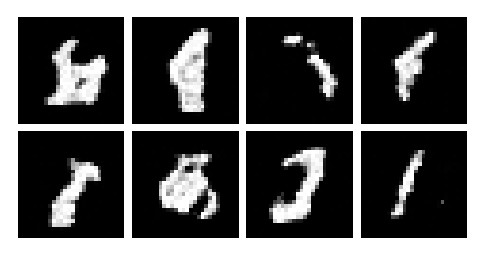

Epoch  11: train NLL/img=-3387.062, val NLL/img=-3394.723, train bpd=-6.2328, val bpd=-6.2469
   train: log_pz=-557.35, ldj=3944.41, log_px=3387.06
   val  : log_pz=-560.27, ldj=3954.99, log_px=3394.72
   ↳ New best model at epoch 11 (val NLL=-3394.723)
Epoch  12: train NLL/img=-3401.285, val NLL/img=-3408.053, train bpd=-6.2589, val bpd=-6.2714
   train: log_pz=-556.58, ldj=3957.86, log_px=3401.28
   val  : log_pz=-561.96, ldj=3970.02, log_px=3408.05
   ↳ New best model at epoch 12 (val NLL=-3408.053)
Epoch  13: train NLL/img=-3411.441, val NLL/img=-3417.340, train bpd=-6.2776, val bpd=-6.2885
   train: log_pz=-556.69, ldj=3968.13, log_px=3411.44
   val  : log_pz=-553.43, ldj=3970.77, log_px=3417.34
   ↳ New best model at epoch 13 (val NLL=-3417.340)
Epoch  14: train NLL/img=-3419.184, val NLL/img=-3428.690, train bpd=-6.2919, val bpd=-6.3094
   train: log_pz=-556.69, ldj=3975.87, log_px=3419.18
   val  : log_pz=-558.48, ldj=3987.17, log_px=3428.69
   ↳ New best model at epoch 14 (val

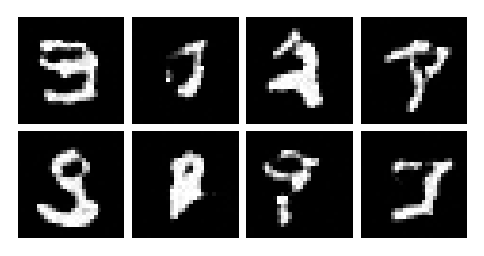

Epoch  21: train NLL/img=-3460.433, val NLL/img=-3461.812, train bpd=-6.3678, val bpd=-6.3703
   train: log_pz=-556.96, ldj=4017.40, log_px=3460.43
   val  : log_pz=-553.79, ldj=4015.60, log_px=3461.81
   ↳ New best model at epoch 21 (val NLL=-3461.812)
Epoch  22: train NLL/img=-3465.094, val NLL/img=-3465.459, train bpd=-6.3764, val bpd=-6.3770
   train: log_pz=-556.88, ldj=4021.97, log_px=3465.09
   val  : log_pz=-569.19, ldj=4034.65, log_px=3465.46
   ↳ New best model at epoch 22 (val NLL=-3465.459)
Epoch  23: train NLL/img=-3469.805, val NLL/img=-3467.130, train bpd=-6.3850, val bpd=-6.3801
   train: log_pz=-557.06, ldj=4026.86, log_px=3469.81
   val  : log_pz=-553.60, ldj=4020.73, log_px=3467.13
   ↳ New best model at epoch 23 (val NLL=-3467.130)
Epoch  24: train NLL/img=-3470.492, val NLL/img=-3473.143, train bpd=-6.3863, val bpd=-6.3912
   train: log_pz=-556.82, ldj=4027.32, log_px=3470.49
   val  : log_pz=-567.87, ldj=4041.01, log_px=3473.14
   ↳ New best model at epoch 24 (val

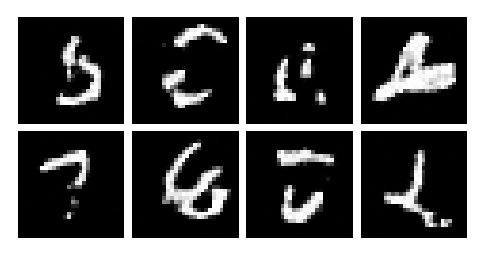

Epoch  31: train NLL/img=-3488.751, val NLL/img=-3494.278, train bpd=-6.4199, val bpd=-6.4301
   train: log_pz=-556.85, ldj=4045.61, log_px=3488.75
   val  : log_pz=-558.87, ldj=4053.15, log_px=3494.28
   ↳ New best model at epoch 31 (val NLL=-3494.278)
Epoch  32: train NLL/img=-3493.100, val NLL/img=-3496.285, train bpd=-6.4279, val bpd=-6.4338
   train: log_pz=-556.94, ldj=4050.04, log_px=3493.10
   val  : log_pz=-554.36, ldj=4050.65, log_px=3496.29
   ↳ New best model at epoch 32 (val NLL=-3496.285)
Epoch  33: train NLL/img=-3497.281, val NLL/img=-3486.994, train bpd=-6.4356, val bpd=-6.4167
   train: log_pz=-556.66, ldj=4053.94, log_px=3497.28
   val  : log_pz=-559.54, ldj=4046.54, log_px=3486.99
Epoch  34: train NLL/img=-3493.940, val NLL/img=-3497.790, train bpd=-6.4295, val bpd=-6.4365
   train: log_pz=-556.94, ldj=4050.88, log_px=3493.94
   val  : log_pz=-559.40, ldj=4057.19, log_px=3497.79
   ↳ New best model at epoch 34 (val NLL=-3497.790)
Epoch  35: train NLL/img=-3499.221, 

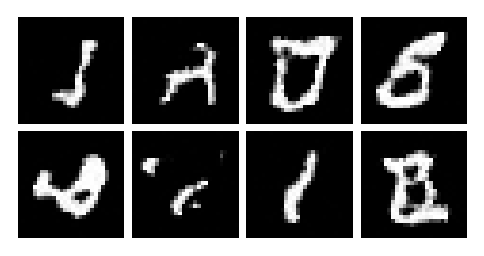

Epoch  41: train NLL/img=-3512.161, val NLL/img=-3515.847, train bpd=-6.4630, val bpd=-6.4698
   train: log_pz=-556.80, ldj=4068.96, log_px=3512.16
   val  : log_pz=-552.69, ldj=4068.53, log_px=3515.85
   ↳ New best model at epoch 41 (val NLL=-3515.847)
Epoch  42: train NLL/img=-3512.508, val NLL/img=-3517.405, train bpd=-6.4636, val bpd=-6.4726
   train: log_pz=-556.96, ldj=4069.47, log_px=3512.51
   val  : log_pz=-546.96, ldj=4064.36, log_px=3517.40
   ↳ New best model at epoch 42 (val NLL=-3517.405)
Epoch  43: train NLL/img=-3518.079, val NLL/img=-3517.369, train bpd=-6.4739, val bpd=-6.4726
   train: log_pz=-556.56, ldj=4074.64, log_px=3518.08
   val  : log_pz=-559.58, ldj=4076.95, log_px=3517.37
Epoch  44: train NLL/img=-3516.312, val NLL/img=-3517.609, train bpd=-6.4706, val bpd=-6.4730
   train: log_pz=-557.05, ldj=4073.36, log_px=3516.31
   val  : log_pz=-557.35, ldj=4074.96, log_px=3517.61
   ↳ New best model at epoch 44 (val NLL=-3517.609)
Epoch  45: train NLL/img=-3518.345, 

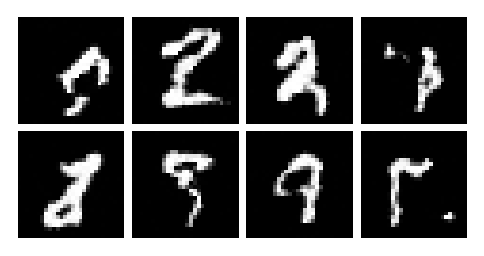

Epoch  51: train NLL/img=-3532.004, val NLL/img=-3532.125, train bpd=-6.4995, val bpd=-6.4997
   train: log_pz=-556.45, ldj=4088.45, log_px=3532.00
   val  : log_pz=-558.62, ldj=4090.74, log_px=3532.12
Epoch  52: train NLL/img=-3530.023, val NLL/img=-3538.779, train bpd=-6.4958, val bpd=-6.5120
   train: log_pz=-556.65, ldj=4086.68, log_px=3530.02
   val  : log_pz=-556.63, ldj=4095.40, log_px=3538.78
   ↳ New best model at epoch 52 (val NLL=-3538.779)
Epoch  53: train NLL/img=-3537.672, val NLL/img=-3535.933, train bpd=-6.5099, val bpd=-6.5067
   train: log_pz=-556.09, ldj=4093.76, log_px=3537.67
   val  : log_pz=-554.61, ldj=4090.54, log_px=3535.93
Epoch  54: train NLL/img=-3534.449, val NLL/img=-3535.056, train bpd=-6.5040, val bpd=-6.5051
   train: log_pz=-556.79, ldj=4091.24, log_px=3534.45
   val  : log_pz=-553.63, ldj=4088.68, log_px=3535.06
Epoch  55: train NLL/img=-3535.908, val NLL/img=-3530.506, train bpd=-6.5067, val bpd=-6.4967
   train: log_pz=-556.37, ldj=4092.27, log_px=

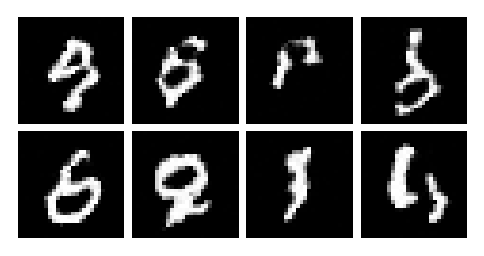

Epoch  61: train NLL/img=-3540.695, val NLL/img=-3544.151, train bpd=-6.5155, val bpd=-6.5218
   train: log_pz=-557.36, ldj=4098.06, log_px=3540.69
   val  : log_pz=-562.26, ldj=4106.41, log_px=3544.15
Epoch  62: train NLL/img=-3544.546, val NLL/img=-3547.323, train bpd=-6.5226, val bpd=-6.5277
   train: log_pz=-556.52, ldj=4101.07, log_px=3544.55
   val  : log_pz=-563.05, ldj=4110.37, log_px=3547.32
Epoch  63: train NLL/img=-3547.639, val NLL/img=-3507.441, train bpd=-6.5283, val bpd=-6.4543
   train: log_pz=-556.12, ldj=4103.76, log_px=3547.64
   val  : log_pz=-582.93, ldj=4090.38, log_px=3507.44
Epoch  64: train NLL/img=-3544.570, val NLL/img=-3529.885, train bpd=-6.5226, val bpd=-6.4956
   train: log_pz=-556.47, ldj=4101.04, log_px=3544.57
   val  : log_pz=-579.21, ldj=4109.09, log_px=3529.89
Epoch  65: train NLL/img=-3548.187, val NLL/img=-3543.926, train bpd=-6.5293, val bpd=-6.5214
   train: log_pz=-556.67, ldj=4104.86, log_px=3548.19
   val  : log_pz=-567.48, ldj=4111.40, log_p

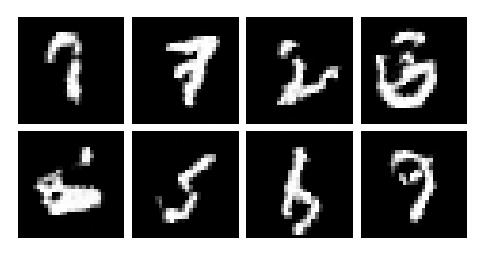

Epoch  71: train NLL/img=-3553.379, val NLL/img=-3554.001, train bpd=-6.5388, val bpd=-6.5400
   train: log_pz=-556.36, ldj=4109.74, log_px=3553.38
   val  : log_pz=-554.67, ldj=4108.67, log_px=3554.00
   ↳ New best model at epoch 71 (val NLL=-3554.001)
Epoch  72: train NLL/img=-3556.006, val NLL/img=-3554.239, train bpd=-6.5437, val bpd=-6.5404
   train: log_pz=-556.32, ldj=4112.32, log_px=3556.01
   val  : log_pz=-571.74, ldj=4125.98, log_px=3554.24
   ↳ New best model at epoch 72 (val NLL=-3554.239)
Epoch  73: train NLL/img=-3553.280, val NLL/img=-3548.623, train bpd=-6.5386, val bpd=-6.5301
   train: log_pz=-556.60, ldj=4109.88, log_px=3553.28
   val  : log_pz=-553.11, ldj=4101.73, log_px=3548.62
Epoch  74: train NLL/img=-3554.634, val NLL/img=-3556.678, train bpd=-6.5411, val bpd=-6.5449
   train: log_pz=-556.94, ldj=4111.57, log_px=3554.63
   val  : log_pz=-555.73, ldj=4112.41, log_px=3556.68
   ↳ New best model at epoch 74 (val NLL=-3556.678)
Epoch  75: train NLL/img=-3556.509, 

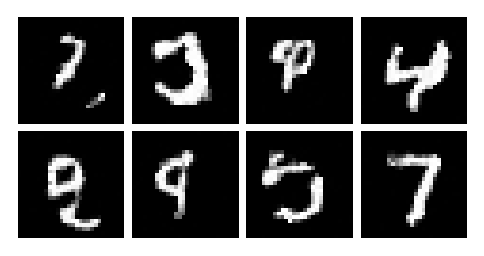

Epoch  81: train NLL/img=-3561.110, val NLL/img=-3559.652, train bpd=-6.5531, val bpd=-6.5504
   train: log_pz=-556.52, ldj=4117.63, log_px=3561.11
   val  : log_pz=-547.96, ldj=4107.61, log_px=3559.65
Epoch  82: train NLL/img=-3559.336, val NLL/img=-3555.525, train bpd=-6.5498, val bpd=-6.5428
   train: log_pz=-556.63, ldj=4115.96, log_px=3559.34
   val  : log_pz=-561.77, ldj=4117.30, log_px=3555.53
Epoch  83: train NLL/img=-3563.185, val NLL/img=-3557.761, train bpd=-6.5569, val bpd=-6.5469
   train: log_pz=-556.33, ldj=4119.51, log_px=3563.18
   val  : log_pz=-552.50, ldj=4110.26, log_px=3557.76
Epoch  84: train NLL/img=-3561.745, val NLL/img=-3566.165, train bpd=-6.5542, val bpd=-6.5624
   train: log_pz=-556.44, ldj=4118.19, log_px=3561.75
   val  : log_pz=-557.07, ldj=4123.24, log_px=3566.17
   ↳ New best model at epoch 84 (val NLL=-3566.165)
Epoch  85: train NLL/img=-3562.500, val NLL/img=-3552.794, train bpd=-6.5556, val bpd=-6.5378
   train: log_pz=-556.63, ldj=4119.13, log_px=

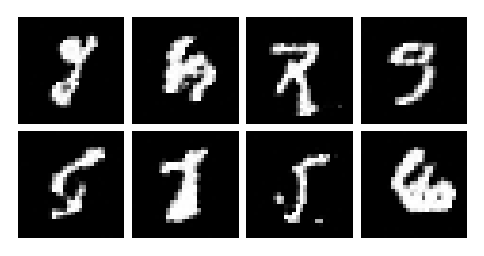

Epoch  91: train NLL/img=-3568.177, val NLL/img=-3535.413, train bpd=-6.5661, val bpd=-6.5058
   train: log_pz=-556.36, ldj=4124.53, log_px=3568.18
   val  : log_pz=-578.06, ldj=4113.48, log_px=3535.41
Epoch  92: train NLL/img=-3563.617, val NLL/img=-2935.810, train bpd=-6.5577, val bpd=-5.4024
   train: log_pz=-556.59, ldj=4120.21, log_px=3563.62
   val  : log_pz=-1160.44, ldj=4096.25, log_px=2935.81
Epoch  93: train NLL/img=-3570.938, val NLL/img=-3042.573, train bpd=-6.5711, val bpd=-5.5989
   train: log_pz=-556.37, ldj=4127.31, log_px=3570.94
   val  : log_pz=-1047.54, ldj=4090.11, log_px=3042.57
Epoch  94: train NLL/img=-3566.311, val NLL/img=-2265.330, train bpd=-6.5626, val bpd=-4.1686
   train: log_pz=-556.63, ldj=4122.94, log_px=3566.31
   val  : log_pz=-1821.43, ldj=4086.76, log_px=2265.33
Epoch  95: train NLL/img=-3570.229, val NLL/img=-1241.814, train bpd=-6.5698, val bpd=-2.2852
   train: log_pz=-556.74, ldj=4126.97, log_px=3570.23
   val  : log_pz=-2858.34, ldj=4100.15, l

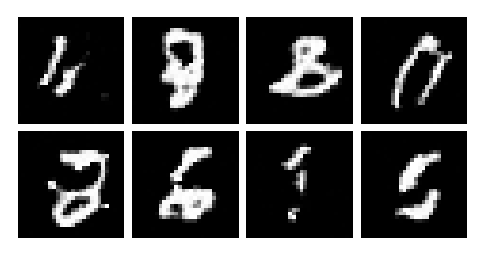


===== Training finished =====
Best epoch: 90
Best val NLL/img: -3568.9702
Best val bpd    : -6.567520
Best val decomposition: log_pz=-556.00, ldj=4124.97, log_px=3568.97


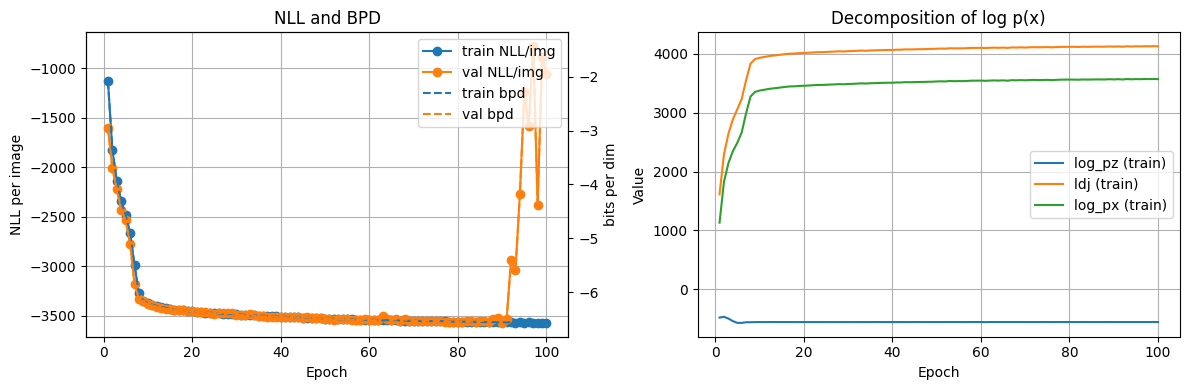

z_all shape: torch.Size([16384, 8, 7, 7])
mean(z_flat) ≈ -0.2867
std(z_flat)  ≈ 1.7957


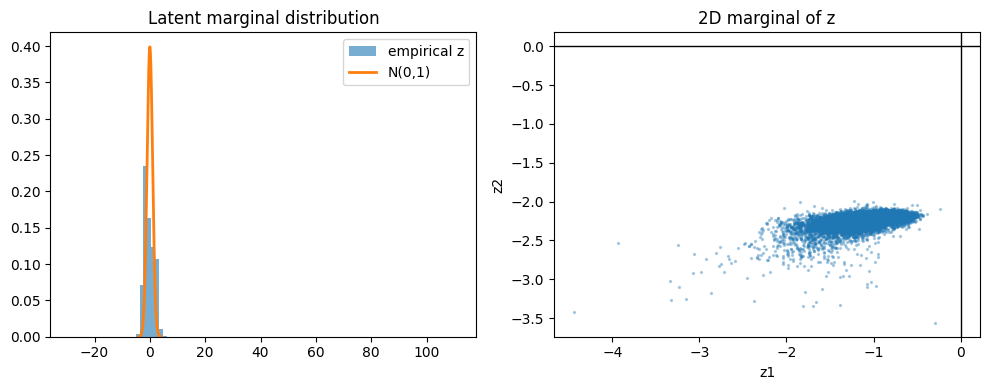

Manual vs model.log_prob:
  max abs diff: 0.0
  mean abs diff: 0.0
Test set:
  NLL/img = -3140.4876
  bpd     = -5.7790
  log_pz  = -1011.74
  ldj     = 4152.23
  log_px  = 3140.49


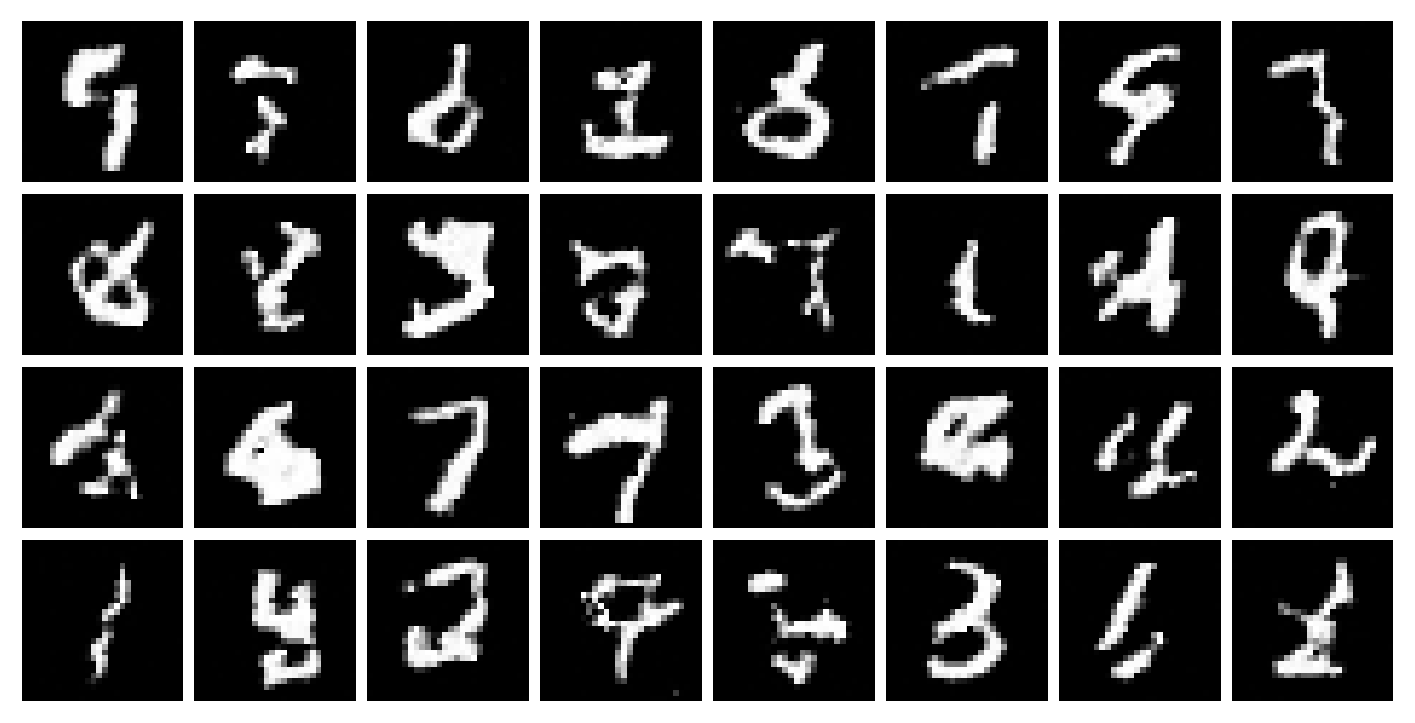

In [ ]:
model = RealNVPMNIST(flows).to(device)
history, best_epoch, best_val = train_realnvp(
    model,
    train_loader=train_digits,
    val_loader=val_digits,
    device=device,
    n_epochs=100,
    lr=5e-4,
    use_dequant=True)

plot_training_history(history)
sanity_check_flow(model, train_digits, device, 128)
evaluate_realnvp(model, test_digits, device)
plot_flow_samples(model, device, n_samples=32)

### BottleneckConvSTNet (ResBlocks×3, hidden=32/64/96), 3-scale flow, 2-2-4 couplings

In [ ]:
flows = []

# Scale 1: 1 × 28 × 28
# 2 coupling layers with checkerboard masks
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=False, st_net=BottleneckConvSTNet(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=True, st_net=BottleneckConvSTNet(c_in=1, hidden_channels=32)))

# Squeeze: 1×28×28 → 4×14×14
flows.append(SqueezeFlow())

# Scale 2: 4 × 14 × 14
# 2 coupling layers with checkerboard masks
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=False, st_net=BottleneckConvSTNet(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=True, st_net=BottleneckConvSTNet(c_in=4, hidden_channels=64)))

# Split: 4×14×14 → 2×14×14
flows.append(SplitFlow())

# Squeeze: 2×14×14 → 8×7×7
flows.append(SqueezeFlow())

# Scale 3: 8 × 7 × 7
# 4 coupling layers with checkerboard + channelwise mix
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="checkerboard", flip=False, st_net=BottleneckConvSTNet(c_in=8, hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="channelwise", flip=False, st_net=BottleneckConvSTNet(c_in=8,hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="checkerboard", flip=True, st_net=BottleneckConvSTNet(c_in=8, hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="channelwise", flip=True, st_net=BottleneckConvSTNet(c_in=8, hidden_channels=96)))

Epoch   1: train NLL/img=-1430.572, val NLL/img=-1672.567, train bpd=-2.6325, val bpd=-3.0778
   train: log_pz=-456.97, ldj=1887.54, log_px=1430.57
   val  : log_pz=-504.80, ldj=2177.37, log_px=1672.57
   ↳ New best model at epoch 1 (val NLL=-1672.567)
Epoch   2: train NLL/img=-1962.038, val NLL/img=-2180.242, train bpd=-3.6105, val bpd=-4.0120
   train: log_pz=-460.28, ldj=2422.32, log_px=1962.04
   val  : log_pz=-477.48, ldj=2657.72, log_px=2180.24
   ↳ New best model at epoch 2 (val NLL=-2180.242)
Epoch   3: train NLL/img=-2347.623, val NLL/img=-2499.746, train bpd=-4.3200, val bpd=-4.6000
   train: log_pz=-500.70, ldj=2848.32, log_px=2347.62
   val  : log_pz=-507.26, ldj=3007.01, log_px=2499.75
   ↳ New best model at epoch 3 (val NLL=-2499.746)
Epoch   4: train NLL/img=-2526.300, val NLL/img=-2325.348, train bpd=-4.6488, val bpd=-4.2790
   train: log_pz=-595.37, ldj=3121.67, log_px=2526.30
   val  : log_pz=-863.30, ldj=3188.64, log_px=2325.35
Epoch   5: train NLL/img=-2796.043, val

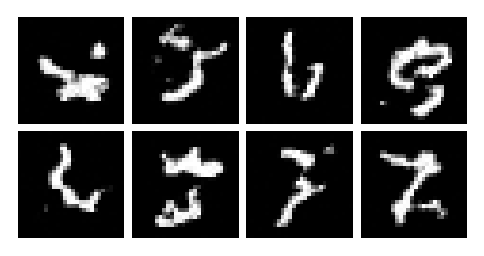

Epoch  11: train NLL/img=-3488.211, val NLL/img=-3472.686, train bpd=-6.4189, val bpd=-6.3903
   train: log_pz=-557.27, ldj=4045.48, log_px=3488.21
   val  : log_pz=-554.31, ldj=4027.00, log_px=3472.69
Epoch  12: train NLL/img=-3497.200, val NLL/img=-3495.341, train bpd=-6.4355, val bpd=-6.4320
   train: log_pz=-557.70, ldj=4054.90, log_px=3497.20
   val  : log_pz=-565.74, ldj=4061.09, log_px=3495.34
   ↳ New best model at epoch 12 (val NLL=-3495.341)
Epoch  13: train NLL/img=-3514.545, val NLL/img=-3508.504, train bpd=-6.4674, val bpd=-6.4563
   train: log_pz=-557.13, ldj=4071.68, log_px=3514.55
   val  : log_pz=-555.86, ldj=4064.37, log_px=3508.50
   ↳ New best model at epoch 13 (val NLL=-3508.504)
Epoch  14: train NLL/img=-3514.828, val NLL/img=-3518.995, train bpd=-6.4679, val bpd=-6.4756
   train: log_pz=-557.26, ldj=4072.09, log_px=3514.83
   val  : log_pz=-563.82, ldj=4082.82, log_px=3518.99
   ↳ New best model at epoch 14 (val NLL=-3518.995)
Epoch  15: train NLL/img=-3528.295, 

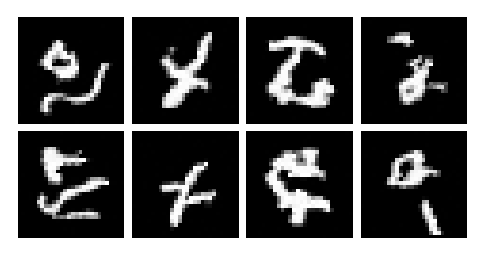

Epoch  21: train NLL/img=-3544.546, val NLL/img=-3535.239, train bpd=-6.5226, val bpd=-6.5054
   train: log_pz=-557.11, ldj=4101.66, log_px=3544.55
   val  : log_pz=-555.80, ldj=4091.04, log_px=3535.24
Epoch  22: train NLL/img=-3545.808, val NLL/img=-3552.808, train bpd=-6.5249, val bpd=-6.5378
   train: log_pz=-556.97, ldj=4102.78, log_px=3545.81
   val  : log_pz=-561.20, ldj=4114.01, log_px=3552.81
Epoch  23: train NLL/img=-3556.671, val NLL/img=-3559.358, train bpd=-6.5449, val bpd=-6.5498
   train: log_pz=-556.73, ldj=4113.41, log_px=3556.67
   val  : log_pz=-555.73, ldj=4115.09, log_px=3559.36
   ↳ New best model at epoch 23 (val NLL=-3559.358)
Epoch  24: train NLL/img=-3557.346, val NLL/img=-3540.817, train bpd=-6.5461, val bpd=-6.5157
   train: log_pz=-557.35, ldj=4114.69, log_px=3557.35
   val  : log_pz=-545.59, ldj=4086.40, log_px=3540.82
Epoch  25: train NLL/img=-3559.814, val NLL/img=-3546.559, train bpd=-6.5507, val bpd=-6.5263
   train: log_pz=-556.73, ldj=4116.54, log_px=

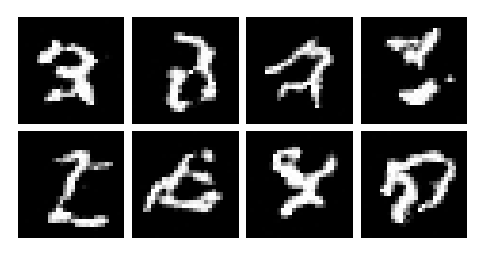

Epoch  31: train NLL/img=-3573.228, val NLL/img=-3571.063, train bpd=-6.5754, val bpd=-6.5714
   train: log_pz=-556.91, ldj=4130.14, log_px=3573.23
   val  : log_pz=-557.86, ldj=4128.92, log_px=3571.06
Epoch  32: train NLL/img=-3575.268, val NLL/img=-3574.590, train bpd=-6.5791, val bpd=-6.5779
   train: log_pz=-556.77, ldj=4132.04, log_px=3575.27
   val  : log_pz=-560.05, ldj=4134.64, log_px=3574.59
Epoch  33: train NLL/img=-3577.214, val NLL/img=-3581.121, train bpd=-6.5827, val bpd=-6.5899
   train: log_pz=-556.86, ldj=4134.07, log_px=3577.21
   val  : log_pz=-555.16, ldj=4136.28, log_px=3581.12
   ↳ New best model at epoch 33 (val NLL=-3581.121)
Epoch  34: train NLL/img=-3580.471, val NLL/img=-3574.029, train bpd=-6.5887, val bpd=-6.5768
   train: log_pz=-556.75, ldj=4137.22, log_px=3580.47
   val  : log_pz=-550.31, ldj=4124.34, log_px=3574.03
Epoch  35: train NLL/img=-3577.176, val NLL/img=-3579.808, train bpd=-6.5826, val bpd=-6.5875
   train: log_pz=-556.84, ldj=4134.02, log_px=

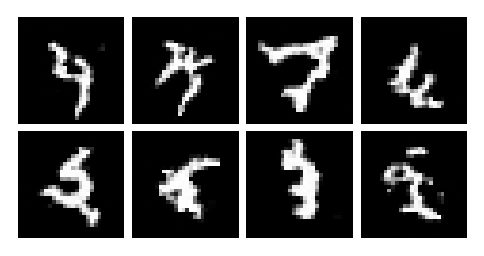

Epoch  41: train NLL/img=-3590.273, val NLL/img=-3593.806, train bpd=-6.6067, val bpd=-6.6132
   train: log_pz=-556.59, ldj=4146.86, log_px=3590.27
   val  : log_pz=-555.87, ldj=4149.68, log_px=3593.81
   ↳ New best model at epoch 41 (val NLL=-3593.806)
Epoch  42: train NLL/img=-3590.728, val NLL/img=-3582.245, train bpd=-6.6076, val bpd=-6.5919
   train: log_pz=-556.76, ldj=4147.49, log_px=3590.73
   val  : log_pz=-553.10, ldj=4135.35, log_px=3582.25
Epoch  43: train NLL/img=-3590.459, val NLL/img=-3573.791, train bpd=-6.6071, val bpd=-6.5764
   train: log_pz=-556.58, ldj=4147.04, log_px=3590.46
   val  : log_pz=-550.89, ldj=4124.69, log_px=3573.79
Epoch  44: train NLL/img=-3590.670, val NLL/img=-3596.737, train bpd=-6.6075, val bpd=-6.6186
   train: log_pz=-556.64, ldj=4147.31, log_px=3590.67
   val  : log_pz=-557.08, ldj=4153.82, log_px=3596.74
   ↳ New best model at epoch 44 (val NLL=-3596.737)
Epoch  45: train NLL/img=-3592.692, val NLL/img=-3593.811, train bpd=-6.6112, val bpd=-6

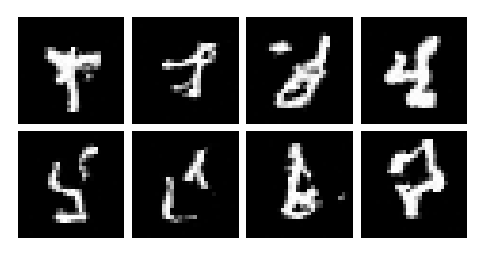

Epoch  51: train NLL/img=-3597.442, val NLL/img=-3604.988, train bpd=-6.6199, val bpd=-6.6338
   train: log_pz=-556.73, ldj=4154.17, log_px=3597.44
   val  : log_pz=-558.50, ldj=4163.49, log_px=3604.99
   ↳ New best model at epoch 51 (val NLL=-3604.988)
Epoch  52: train NLL/img=-3601.709, val NLL/img=-3602.313, train bpd=-6.6278, val bpd=-6.6289
   train: log_pz=-556.57, ldj=4158.28, log_px=3601.71
   val  : log_pz=-559.16, ldj=4161.47, log_px=3602.31
Epoch  53: train NLL/img=-3594.067, val NLL/img=-3597.813, train bpd=-6.6137, val bpd=-6.6206
   train: log_pz=-556.57, ldj=4150.64, log_px=3594.07
   val  : log_pz=-562.76, ldj=4160.57, log_px=3597.81
Epoch  54: train NLL/img=-3596.185, val NLL/img=-3588.530, train bpd=-6.6176, val bpd=-6.6035
   train: log_pz=-556.55, ldj=4152.74, log_px=3596.19
   val  : log_pz=-557.49, ldj=4146.02, log_px=3588.53
Epoch  55: train NLL/img=-3603.729, val NLL/img=-3605.213, train bpd=-6.6315, val bpd=-6.6342
   train: log_pz=-556.51, ldj=4160.24, log_px=

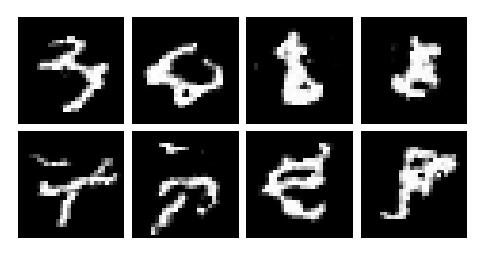

Epoch  61: train NLL/img=-3602.991, val NLL/img=-3600.589, train bpd=-6.6301, val bpd=-6.6257
   train: log_pz=-556.32, ldj=4159.31, log_px=3602.99
   val  : log_pz=-555.44, ldj=4156.03, log_px=3600.59
Epoch  62: train NLL/img=-3607.656, val NLL/img=-3605.653, train bpd=-6.6387, val bpd=-6.6350
   train: log_pz=-556.55, ldj=4164.21, log_px=3607.66
   val  : log_pz=-554.60, ldj=4160.26, log_px=3605.65
Epoch  63: train NLL/img=-3600.702, val NLL/img=-3586.178, train bpd=-6.6259, val bpd=-6.5992
   train: log_pz=-557.00, ldj=4157.70, log_px=3600.70
   val  : log_pz=-560.49, ldj=4146.66, log_px=3586.18
Epoch  64: train NLL/img=-3606.396, val NLL/img=-3606.247, train bpd=-6.6364, val bpd=-6.6361
   train: log_pz=-556.69, ldj=4163.08, log_px=3606.40
   val  : log_pz=-557.86, ldj=4164.11, log_px=3606.25
Epoch  65: train NLL/img=-3610.258, val NLL/img=-3615.358, train bpd=-6.6435, val bpd=-6.6529
   train: log_pz=-556.36, ldj=4166.62, log_px=3610.26
   val  : log_pz=-553.92, ldj=4169.28, log_p

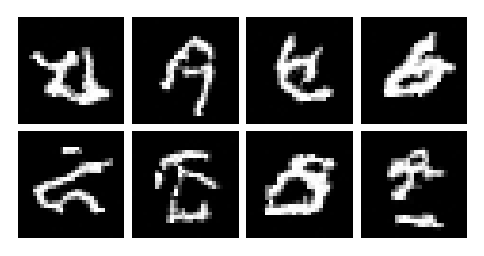

Epoch  71: train NLL/img=-3596.602, val NLL/img=-3610.655, train bpd=-6.6184, val bpd=-6.6442
   train: log_pz=-556.29, ldj=4152.89, log_px=3596.60
   val  : log_pz=-555.16, ldj=4165.82, log_px=3610.66
Epoch  72: train NLL/img=-3608.450, val NLL/img=-3604.118, train bpd=-6.6402, val bpd=-6.6322
   train: log_pz=-556.64, ldj=4165.09, log_px=3608.45
   val  : log_pz=-549.45, ldj=4153.57, log_px=3604.12
Epoch  73: train NLL/img=-3614.150, val NLL/img=-3608.428, train bpd=-6.6507, val bpd=-6.6401
   train: log_pz=-556.39, ldj=4170.54, log_px=3614.15
   val  : log_pz=-556.59, ldj=4165.02, log_px=3608.43
Epoch  74: train NLL/img=-3615.135, val NLL/img=-3615.813, train bpd=-6.6525, val bpd=-6.6537
   train: log_pz=-556.34, ldj=4171.48, log_px=3615.13
   val  : log_pz=-552.26, ldj=4168.08, log_px=3615.81
   ↳ New best model at epoch 74 (val NLL=-3615.813)
Epoch  75: train NLL/img=-3614.554, val NLL/img=-3615.463, train bpd=-6.6514, val bpd=-6.6531
   train: log_pz=-556.69, ldj=4171.24, log_px=

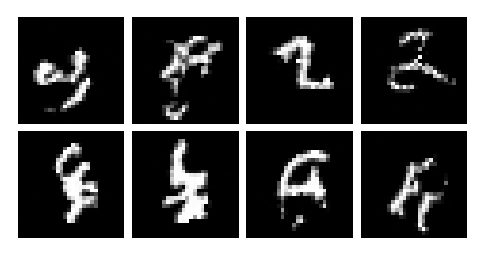

Epoch  81: train NLL/img=-3618.855, val NLL/img=-3619.250, train bpd=-6.6593, val bpd=-6.6600
   train: log_pz=-556.41, ldj=4175.27, log_px=3618.86
   val  : log_pz=-553.83, ldj=4173.08, log_px=3619.25
Epoch  82: train NLL/img=-3617.374, val NLL/img=-3618.420, train bpd=-6.6566, val bpd=-6.6585
   train: log_pz=-556.57, ldj=4173.94, log_px=3617.37
   val  : log_pz=-556.93, ldj=4175.35, log_px=3618.42
Epoch  83: train NLL/img=-3617.713, val NLL/img=-3617.126, train bpd=-6.6572, val bpd=-6.6561
   train: log_pz=-556.56, ldj=4174.27, log_px=3617.71
   val  : log_pz=-555.33, ldj=4172.45, log_px=3617.13
Epoch  84: train NLL/img=-3618.209, val NLL/img=-3613.366, train bpd=-6.6581, val bpd=-6.6492
   train: log_pz=-556.47, ldj=4174.68, log_px=3618.21
   val  : log_pz=-558.77, ldj=4172.13, log_px=3613.37
Epoch  85: train NLL/img=-3618.987, val NLL/img=-3621.925, train bpd=-6.6596, val bpd=-6.6650
   train: log_pz=-556.54, ldj=4175.53, log_px=3618.99
   val  : log_pz=-554.55, ldj=4176.47, log_p

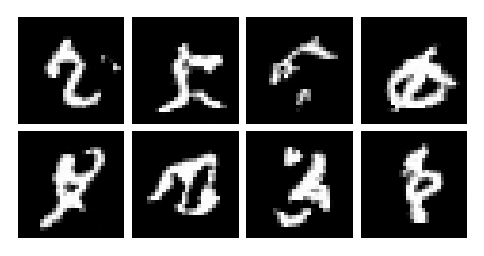

Epoch  91: train NLL/img=-3618.901, val NLL/img=-3622.306, train bpd=-6.6594, val bpd=-6.6657
   train: log_pz=-556.46, ldj=4175.36, log_px=3618.90
   val  : log_pz=-555.04, ldj=4177.35, log_px=3622.31
Epoch  92: train NLL/img=-3616.133, val NLL/img=-3608.047, train bpd=-6.6543, val bpd=-6.6394
   train: log_pz=-556.42, ldj=4172.55, log_px=3616.13
   val  : log_pz=-565.30, ldj=4173.34, log_px=3608.05
Epoch  93: train NLL/img=-3621.742, val NLL/img=-3610.822, train bpd=-6.6646, val bpd=-6.6445
   train: log_pz=-556.47, ldj=4178.21, log_px=3621.74
   val  : log_pz=-561.90, ldj=4172.72, log_px=3610.82
Epoch  94: train NLL/img=-3624.583, val NLL/img=-3625.833, train bpd=-6.6699, val bpd=-6.6722
   train: log_pz=-556.40, ldj=4180.98, log_px=3624.58
   val  : log_pz=-556.07, ldj=4181.90, log_px=3625.83
   ↳ New best model at epoch 94 (val NLL=-3625.833)
Epoch  95: train NLL/img=-3626.174, val NLL/img=-3622.152, train bpd=-6.6728, val bpd=-6.6654
   train: log_pz=-556.36, ldj=4182.53, log_px=

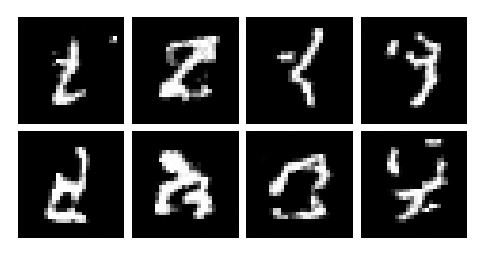


===== Training finished =====
Best epoch: 94
Best val NLL/img: -3625.8333
Best val bpd    : -6.672158
Best val decomposition: log_pz=-556.07, ldj=4181.90, log_px=3625.83


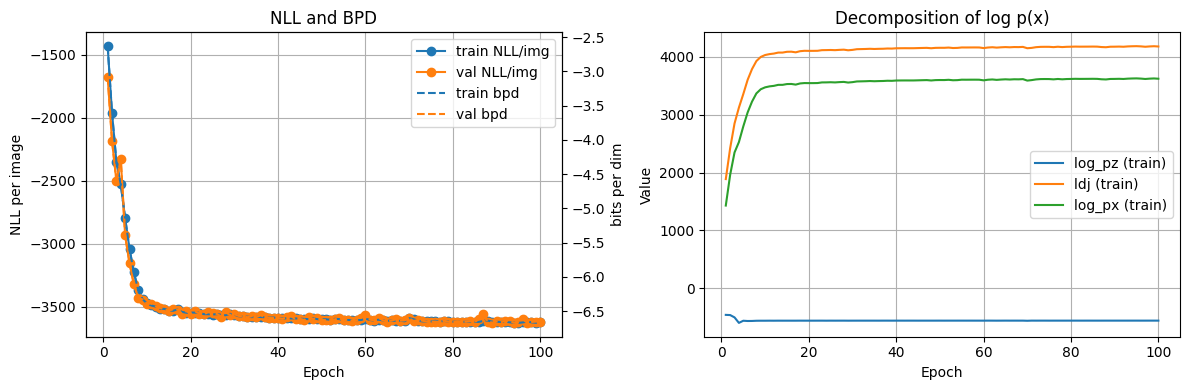

z_all shape: torch.Size([16384, 8, 7, 7])
mean(z_flat) ≈ -0.8663
std(z_flat)  ≈ 1.0450


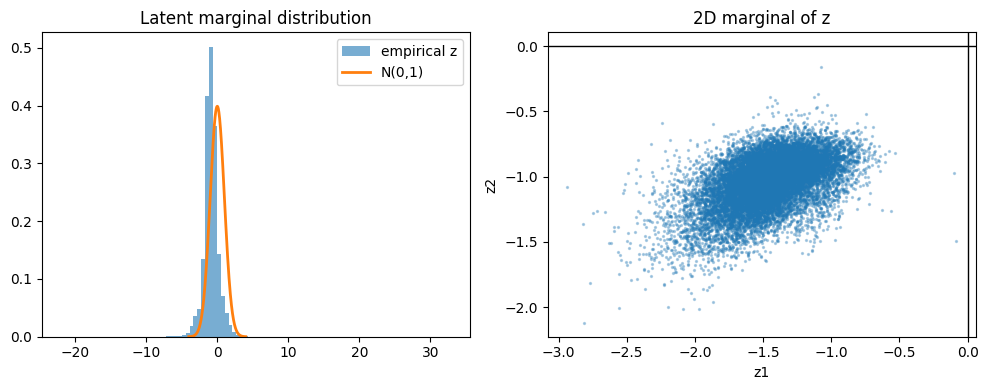

Manual vs model.log_prob:
  max abs diff: 0.0
  mean abs diff: 0.0
Test set:
  NLL/img = -3128.2032
  bpd     = -5.7564
  log_pz  = -719.79
  ldj     = 3847.99
  log_px  = 3128.20


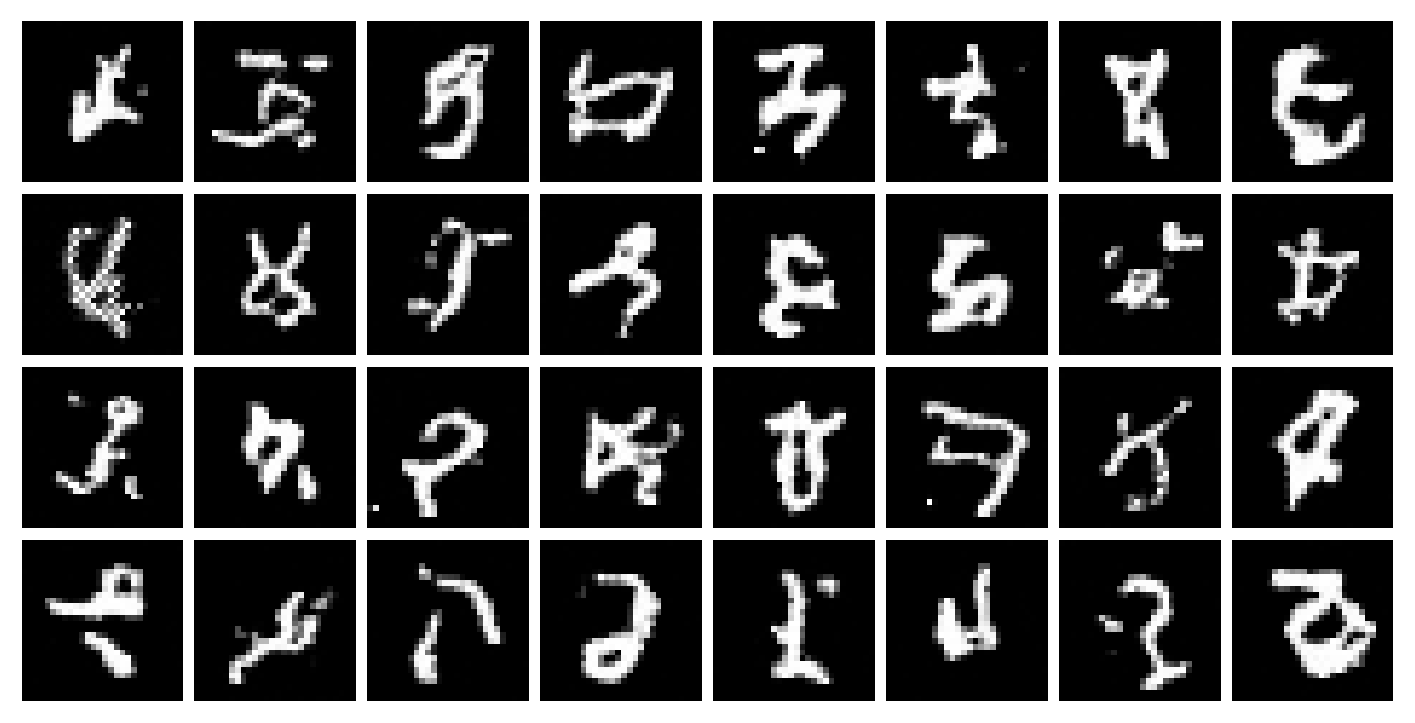

In [ ]:
model = RealNVPMNIST(flows).to(device)
history, best_epoch, best_val = train_realnvp(
    model,
    train_loader=train_digits,
    val_loader=val_digits,
    device=device,
    n_epochs=100,
    lr=5e-4,
    use_dequant=True)

plot_training_history(history)
sanity_check_flow(model, train_digits, device, 128)
evaluate_realnvp(model, test_digits, device)
plot_flow_samples(model, device, n_samples=32)

### GatedConvNet (GatedResNet×3, hidden=32/64/96), 3-scale flow, 2-2-4 couplings

In [ ]:
flows = []

# Scale 1: 1 × 28 × 28
# 2 coupling layers with checkerboard masks
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=False, st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=True, st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))

# Squeeze: 1×28×28 → 4×14×14
flows.append(SqueezeFlow())

# Scale 2: 4 × 14 × 14 =====
# 2 coupling layers with checkerboard masks
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=False, st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=True, st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))

# Split: 4×14×14 → 2×14×14
flows.append(SplitFlow())

# Squeeze: 2×14×14 → 8×7×7
flows.append(SqueezeFlow())

# Scale 3: 8 × 7 × 7
# 4 coupling layers with checkerboard + channelwise mix
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="checkerboard", flip=False, st_net=GatedSTWrapper(c_in=8, hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="channelwise", flip=False, st_net=GatedSTWrapper(c_in=8,hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="checkerboard", flip=True, st_net=GatedSTWrapper(c_in=8, hidden_channels=96)))
flows.append(CouplingLayer(c_in=8, hidden=96, mask_type="channelwise", flip=True, st_net=GatedSTWrapper(c_in=8, hidden_channels=96)))

Epoch   1: train NLL/img=-1391.597, val NLL/img=-1703.443, train bpd=-2.5608, val bpd=-3.1346
   train: log_pz=-452.56, ldj=1844.16, log_px=1391.60
   val  : log_pz=-453.01, ldj=2156.45, log_px=1703.44
   ↳ New best model at epoch 1 (val NLL=-1703.443)
Epoch   2: train NLL/img=-1925.527, val NLL/img=-2116.356, train bpd=-3.5433, val bpd=-3.8945
   train: log_pz=-454.30, ldj=2379.83, log_px=1925.53
   val  : log_pz=-478.52, ldj=2594.88, log_px=2116.36
   ↳ New best model at epoch 2 (val NLL=-2116.356)
Epoch   3: train NLL/img=-2287.416, val NLL/img=-2347.295, train bpd=-4.2092, val bpd=-4.3194
   train: log_pz=-486.25, ldj=2773.67, log_px=2287.42
   val  : log_pz=-573.90, ldj=2921.20, log_px=2347.29
   ↳ New best model at epoch 3 (val NLL=-2347.295)
Epoch   4: train NLL/img=-2530.618, val NLL/img=-2579.794, train bpd=-4.6568, val bpd=-4.7473
   train: log_pz=-529.96, ldj=3060.58, log_px=2530.62
   val  : log_pz=-582.26, ldj=3162.06, log_px=2579.79
   ↳ New best model at epoch 4 (val NLL

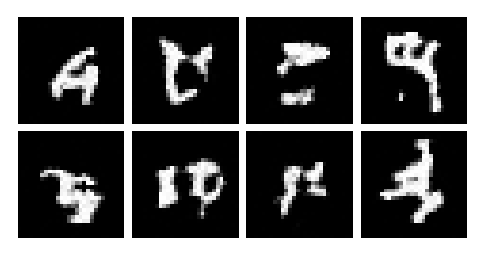

Epoch  11: train NLL/img=-3450.209, val NLL/img=-3442.782, train bpd=-6.3490, val bpd=-6.3353
   train: log_pz=-557.51, ldj=4007.72, log_px=3450.21
   val  : log_pz=-557.75, ldj=4000.53, log_px=3442.78
Epoch  12: train NLL/img=-3460.028, val NLL/img=-3485.340, train bpd=-6.3670, val bpd=-6.4136
   train: log_pz=-557.42, ldj=4017.45, log_px=3460.03
   val  : log_pz=-561.06, ldj=4046.40, log_px=3485.34
   ↳ New best model at epoch 12 (val NLL=-3485.340)
Epoch  13: train NLL/img=-3479.471, val NLL/img=-3492.533, train bpd=-6.4028, val bpd=-6.4269
   train: log_pz=-556.97, ldj=4036.44, log_px=3479.47
   val  : log_pz=-553.44, ldj=4045.97, log_px=3492.53
   ↳ New best model at epoch 13 (val NLL=-3492.533)
Epoch  14: train NLL/img=-3489.307, val NLL/img=-3497.984, train bpd=-6.4209, val bpd=-6.4369
   train: log_pz=-556.95, ldj=4046.26, log_px=3489.31
   val  : log_pz=-565.81, ldj=4063.79, log_px=3497.98
   ↳ New best model at epoch 14 (val NLL=-3497.984)
Epoch  15: train NLL/img=-3505.421, 

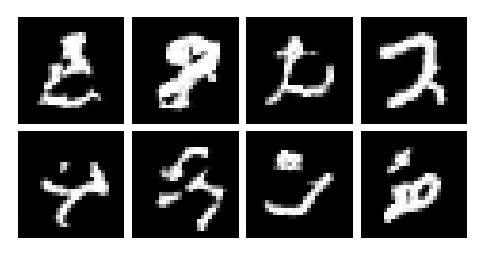

Epoch  21: train NLL/img=-3540.314, val NLL/img=-3547.433, train bpd=-6.5148, val bpd=-6.5279
   train: log_pz=-557.27, ldj=4097.58, log_px=3540.31
   val  : log_pz=-558.45, ldj=4105.88, log_px=3547.43
   ↳ New best model at epoch 21 (val NLL=-3547.433)
Epoch  22: train NLL/img=-3545.920, val NLL/img=-3558.144, train bpd=-6.5251, val bpd=-6.5476
   train: log_pz=-557.25, ldj=4103.17, log_px=3545.92
   val  : log_pz=-559.80, ldj=4117.95, log_px=3558.14
   ↳ New best model at epoch 22 (val NLL=-3558.144)
Epoch  23: train NLL/img=-3553.516, val NLL/img=-3551.695, train bpd=-6.5391, val bpd=-6.5357
   train: log_pz=-556.89, ldj=4110.41, log_px=3553.52
   val  : log_pz=-550.35, ldj=4102.04, log_px=3551.69
Epoch  24: train NLL/img=-3558.803, val NLL/img=-3554.540, train bpd=-6.5488, val bpd=-6.5410
   train: log_pz=-557.28, ldj=4116.09, log_px=3558.80
   val  : log_pz=-557.16, ldj=4111.70, log_px=3554.54
Epoch  25: train NLL/img=-3560.866, val NLL/img=-3561.452, train bpd=-6.5526, val bpd=-6

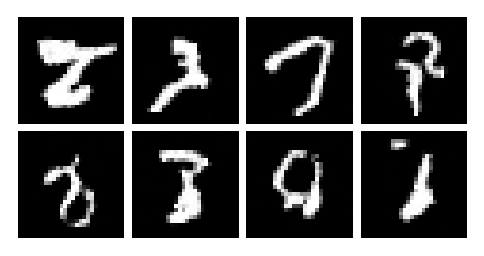

Epoch  31: train NLL/img=-3575.370, val NLL/img=-3590.443, train bpd=-6.5793, val bpd=-6.6070
   train: log_pz=-557.47, ldj=4132.84, log_px=3575.37
   val  : log_pz=-555.04, ldj=4145.48, log_px=3590.44
   ↳ New best model at epoch 31 (val NLL=-3590.443)
Epoch  32: train NLL/img=-3580.448, val NLL/img=-3575.762, train bpd=-6.5886, val bpd=-6.5800
   train: log_pz=-557.59, ldj=4138.04, log_px=3580.45
   val  : log_pz=-549.71, ldj=4125.48, log_px=3575.76
Epoch  33: train NLL/img=-3582.868, val NLL/img=-3578.183, train bpd=-6.5931, val bpd=-6.5845
   train: log_pz=-557.38, ldj=4140.25, log_px=3582.87
   val  : log_pz=-537.31, ldj=4115.49, log_px=3578.18
Epoch  34: train NLL/img=-3585.541, val NLL/img=-3579.182, train bpd=-6.5980, val bpd=-6.5863
   train: log_pz=-557.23, ldj=4142.77, log_px=3585.54
   val  : log_pz=-566.38, ldj=4145.56, log_px=3579.18
Epoch  35: train NLL/img=-3589.019, val NLL/img=-3579.902, train bpd=-6.6044, val bpd=-6.5876
   train: log_pz=-557.65, ldj=4146.67, log_px=

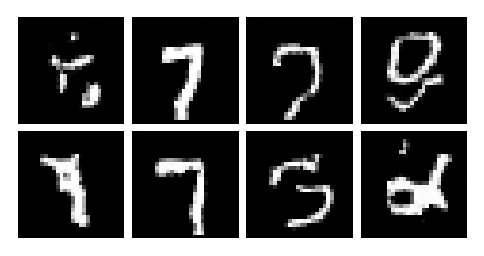

Epoch  41: train NLL/img=-3598.249, val NLL/img=-3596.717, train bpd=-6.6214, val bpd=-6.6186
   train: log_pz=-557.28, ldj=4155.53, log_px=3598.25
   val  : log_pz=-558.08, ldj=4154.79, log_px=3596.72
Epoch  42: train NLL/img=-3599.367, val NLL/img=-3605.143, train bpd=-6.6235, val bpd=-6.6341
   train: log_pz=-557.73, ldj=4157.10, log_px=3599.37
   val  : log_pz=-552.24, ldj=4157.38, log_px=3605.14
Epoch  43: train NLL/img=-3604.882, val NLL/img=-3602.593, train bpd=-6.6336, val bpd=-6.6294
   train: log_pz=-557.35, ldj=4162.24, log_px=3604.88
   val  : log_pz=-562.37, ldj=4164.96, log_px=3602.59
Epoch  44: train NLL/img=-3602.230, val NLL/img=-3597.744, train bpd=-6.6287, val bpd=-6.6205
   train: log_pz=-557.45, ldj=4159.68, log_px=3602.23
   val  : log_pz=-561.49, ldj=4159.23, log_px=3597.74
Epoch  45: train NLL/img=-3604.235, val NLL/img=-3604.627, train bpd=-6.6324, val bpd=-6.6331
   train: log_pz=-556.96, ldj=4161.19, log_px=3604.23
   val  : log_pz=-546.19, ldj=4150.82, log_p

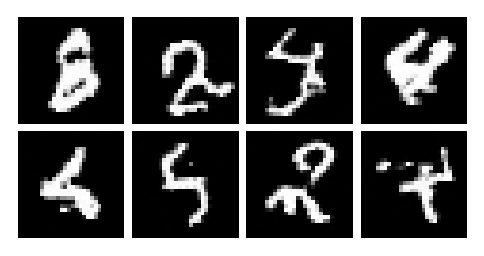

Epoch  51: train NLL/img=-3613.080, val NLL/img=-3611.358, train bpd=-6.6487, val bpd=-6.6455
   train: log_pz=-556.93, ldj=4170.01, log_px=3613.08
   val  : log_pz=-555.55, ldj=4166.91, log_px=3611.36
Epoch  52: train NLL/img=-3615.867, val NLL/img=-3618.555, train bpd=-6.6538, val bpd=-6.6588
   train: log_pz=-557.26, ldj=4173.13, log_px=3615.87
   val  : log_pz=-558.82, ldj=4177.37, log_px=3618.55
   ↳ New best model at epoch 52 (val NLL=-3618.555)
Epoch  53: train NLL/img=-3617.190, val NLL/img=-3619.539, train bpd=-6.6563, val bpd=-6.6606
   train: log_pz=-557.27, ldj=4174.46, log_px=3617.19
   val  : log_pz=-542.93, ldj=4162.47, log_px=3619.54
   ↳ New best model at epoch 53 (val NLL=-3619.539)
Epoch  54: train NLL/img=-3615.667, val NLL/img=-3614.692, train bpd=-6.6534, val bpd=-6.6517
   train: log_pz=-557.25, ldj=4172.92, log_px=3615.67
   val  : log_pz=-554.79, ldj=4169.48, log_px=3614.69
Epoch  55: train NLL/img=-3617.873, val NLL/img=-3608.965, train bpd=-6.6575, val bpd=-6

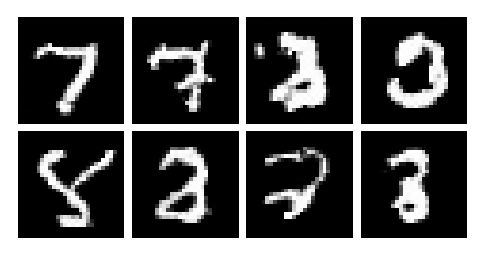

Epoch  61: train NLL/img=-3624.282, val NLL/img=-3621.949, train bpd=-6.6693, val bpd=-6.6650
   train: log_pz=-557.29, ldj=4181.57, log_px=3624.28
   val  : log_pz=-550.87, ldj=4172.82, log_px=3621.95
Epoch  62: train NLL/img=-3627.037, val NLL/img=-3628.140, train bpd=-6.6744, val bpd=-6.6764
   train: log_pz=-557.20, ldj=4184.24, log_px=3627.04
   val  : log_pz=-556.75, ldj=4184.89, log_px=3628.14
Epoch  63: train NLL/img=-3600.992, val NLL/img=-3601.049, train bpd=-6.6264, val bpd=-6.6265
   train: log_pz=-557.57, ldj=4158.56, log_px=3600.99
   val  : log_pz=-556.20, ldj=4157.25, log_px=3601.05
Epoch  64: train NLL/img=-3616.896, val NLL/img=-3610.897, train bpd=-6.6557, val bpd=-6.6447
   train: log_pz=-557.36, ldj=4174.26, log_px=3616.90
   val  : log_pz=-561.39, ldj=4172.28, log_px=3610.90
Epoch  65: train NLL/img=-3623.136, val NLL/img=-3625.367, train bpd=-6.6672, val bpd=-6.6713
   train: log_pz=-557.12, ldj=4180.26, log_px=3623.14
   val  : log_pz=-548.22, ldj=4173.59, log_p

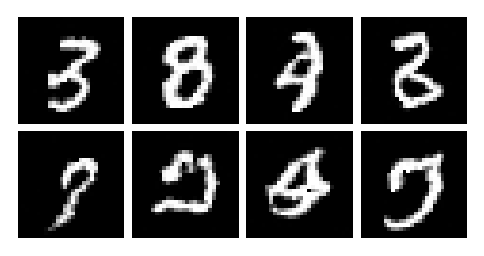

Epoch  71: train NLL/img=-3631.177, val NLL/img=-3631.446, train bpd=-6.6820, val bpd=-6.6825
   train: log_pz=-557.40, ldj=4188.58, log_px=3631.18
   val  : log_pz=-560.24, ldj=4191.69, log_px=3631.45
Epoch  72: train NLL/img=-3633.637, val NLL/img=-3629.689, train bpd=-6.6865, val bpd=-6.6793
   train: log_pz=-556.96, ldj=4190.59, log_px=3633.64
   val  : log_pz=-554.90, ldj=4184.59, log_px=3629.69
Epoch  73: train NLL/img=-3635.164, val NLL/img=-3634.882, train bpd=-6.6893, val bpd=-6.6888
   train: log_pz=-557.25, ldj=4192.42, log_px=3635.16
   val  : log_pz=-562.57, ldj=4197.45, log_px=3634.88
   ↳ New best model at epoch 73 (val NLL=-3634.882)
Epoch  74: train NLL/img=-3635.735, val NLL/img=-3633.721, train bpd=-6.6904, val bpd=-6.6867
   train: log_pz=-557.09, ldj=4192.82, log_px=3635.74
   val  : log_pz=-544.41, ldj=4178.13, log_px=3633.72
Epoch  75: train NLL/img=-3632.600, val NLL/img=-3627.213, train bpd=-6.6846, val bpd=-6.6747
   train: log_pz=-557.03, ldj=4189.63, log_px=

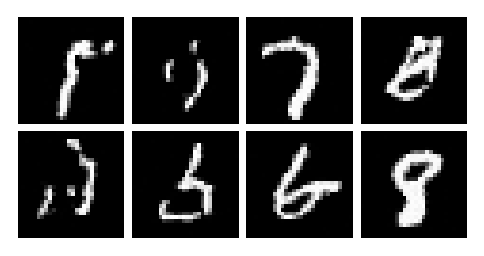

Epoch  81: train NLL/img=-3631.853, val NLL/img=-3632.212, train bpd=-6.6832, val bpd=-6.6839
   train: log_pz=-557.63, ldj=4189.48, log_px=3631.85
   val  : log_pz=-553.36, ldj=4185.57, log_px=3632.21
Epoch  82: train NLL/img=-3638.027, val NLL/img=-3630.790, train bpd=-6.6946, val bpd=-6.6813
   train: log_pz=-557.32, ldj=4195.35, log_px=3638.03
   val  : log_pz=-563.98, ldj=4194.77, log_px=3630.79
Epoch  83: train NLL/img=-3641.734, val NLL/img=-3639.466, train bpd=-6.7014, val bpd=-6.6972
   train: log_pz=-556.87, ldj=4198.61, log_px=3641.73
   val  : log_pz=-565.44, ldj=4204.90, log_px=3639.47
   ↳ New best model at epoch 83 (val NLL=-3639.466)
Epoch  84: train NLL/img=-3639.607, val NLL/img=-3635.899, train bpd=-6.6975, val bpd=-6.6907
   train: log_pz=-556.76, ldj=4196.37, log_px=3639.61
   val  : log_pz=-553.57, ldj=4189.47, log_px=3635.90
Epoch  85: train NLL/img=-3630.132, val NLL/img=-3636.920, train bpd=-6.6801, val bpd=-6.6926
   train: log_pz=-557.21, ldj=4187.34, log_px=

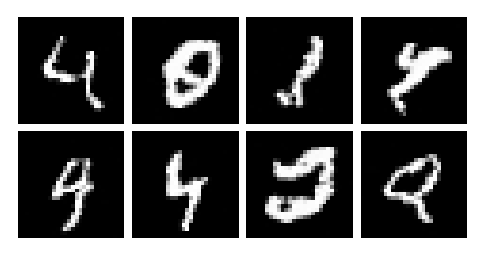

Epoch  91: train NLL/img=-3645.499, val NLL/img=-3643.035, train bpd=-6.7083, val bpd=-6.7038
   train: log_pz=-557.01, ldj=4202.50, log_px=3645.50
   val  : log_pz=-564.32, ldj=4207.36, log_px=3643.04
   ↳ New best model at epoch 91 (val NLL=-3643.035)
Epoch  92: train NLL/img=-3643.807, val NLL/img=-3643.295, train bpd=-6.7052, val bpd=-6.7043
   train: log_pz=-557.14, ldj=4200.95, log_px=3643.81
   val  : log_pz=-554.36, ldj=4197.65, log_px=3643.30
   ↳ New best model at epoch 92 (val NLL=-3643.295)
Epoch  93: train NLL/img=-3646.855, val NLL/img=-3653.041, train bpd=-6.7108, val bpd=-6.7222
   train: log_pz=-556.95, ldj=4203.80, log_px=3646.86
   val  : log_pz=-554.53, ldj=4207.57, log_px=3653.04
   ↳ New best model at epoch 93 (val NLL=-3653.041)
Epoch  94: train NLL/img=-3648.778, val NLL/img=-3651.377, train bpd=-6.7144, val bpd=-6.7192
   train: log_pz=-556.97, ldj=4205.75, log_px=3648.78
   val  : log_pz=-549.00, ldj=4200.38, log_px=3651.38
Epoch  95: train NLL/img=-3645.738, 

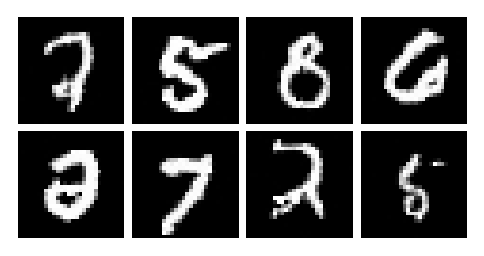


===== Training finished =====
Best epoch: 97
Best val NLL/img: -3656.2959
Best val bpd    : -6.728214
Best val decomposition: log_pz=-565.12, ldj=4221.42, log_px=3656.30


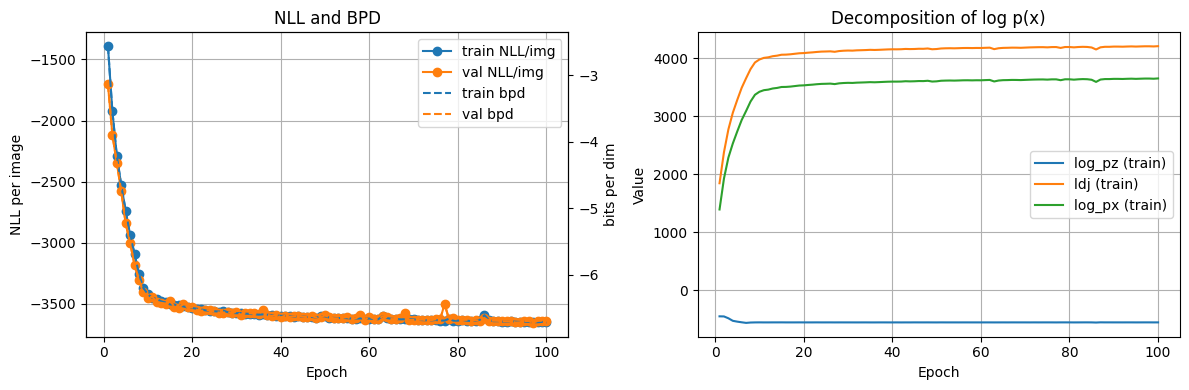

z_all shape: torch.Size([16384, 8, 7, 7])
mean(z_flat) ≈ -1.2714
std(z_flat)  ≈ 1.5060


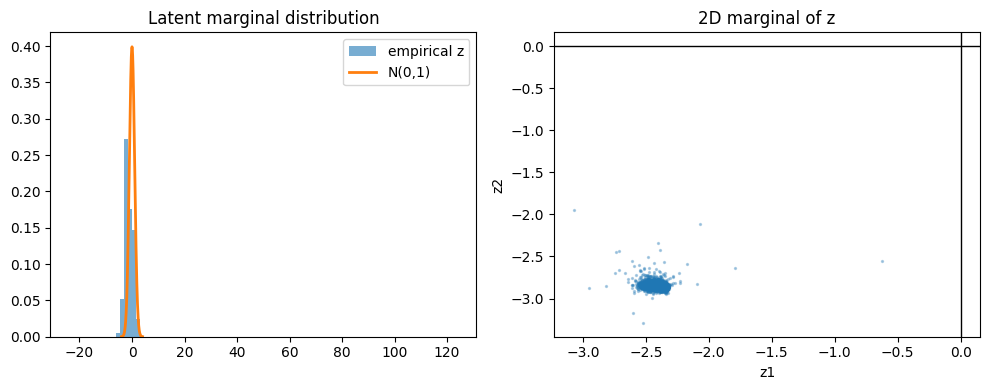

Manual vs model.log_prob:
  max abs diff: 0.0
  mean abs diff: 0.0
Test set:
  NLL/img = -3154.0493
  bpd     = -5.8040
  log_pz  = -1121.52
  ldj     = 4275.57
  log_px  = 3154.05


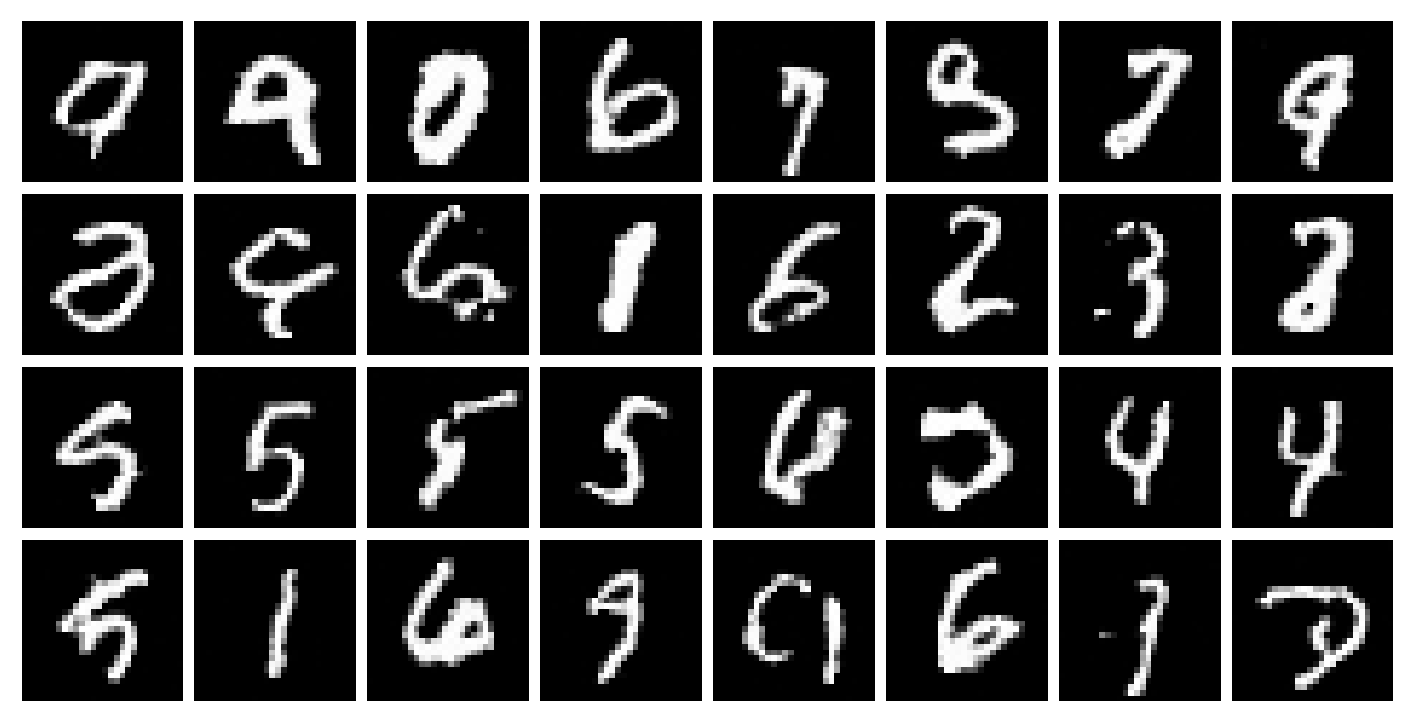

In [ ]:
model = RealNVPMNIST(flows).to(device)
history, best_epoch, best_val = train_realnvp(
    model,
    train_loader=train_digits,
    val_loader=val_digits,
    device=device,
    n_epochs=100,
    lr=5e-4,
    use_dequant=True)

plot_training_history(history)
sanity_check_flow(model, train_digits, device, 128)
evaluate_realnvp(model, test_digits, device)
plot_flow_samples(model, device, n_samples=32)

### GatedConvNet + ActNorm, deeper (4 + 6 + 8 couplings), hidden=32/64/128

In [ ]:
flows = []

# Scale 1: 1×28×28
flows.append(ActNorm2d(1))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))

# Squeeze: 1×28×28 → 4×14×14
flows.append(SqueezeFlow())

# Scale 2: 4×14×14 (Medium-scale)
flows.append(ActNorm2d(4))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="channelwise", flip=False,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))

# Split: 4×14×14 → 2×14×14
flows.append(SplitFlow())

# Squeeze: 2×14×14 → 8×7×7
flows.append(SqueezeFlow())

# Scale 3: 8×7×7
flows.append(ActNorm2d(8))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))

Epoch   1: train NLL/img=-2630.017, val NLL/img=-2972.007, train bpd=-4.8397, val bpd=-5.4690
   train: log_pz=-625.31, ldj=3255.33, log_px=2630.02
   val  : log_pz=-619.26, ldj=3591.27, log_px=2972.01
   ↳ New best model at epoch 1 (val NLL=-2972.007)
Epoch   2: train NLL/img=-3164.020, val NLL/img=-3206.619, train bpd=-5.8223, val bpd=-5.9007
   train: log_pz=-559.93, ldj=3723.95, log_px=3164.02
   val  : log_pz=-585.09, ldj=3791.71, log_px=3206.62
   ↳ New best model at epoch 2 (val NLL=-3206.619)
Epoch   3: train NLL/img=-3247.714, val NLL/img=-3297.759, train bpd=-5.9764, val bpd=-6.0684
   train: log_pz=-561.78, ldj=3809.49, log_px=3247.71
   val  : log_pz=-535.05, ldj=3832.80, log_px=3297.76
   ↳ New best model at epoch 3 (val NLL=-3297.759)
Epoch   4: train NLL/img=-3308.190, val NLL/img=-3304.983, train bpd=-6.0876, val bpd=-6.0817
   train: log_pz=-561.82, ldj=3870.01, log_px=3308.19
   val  : log_pz=-572.36, ldj=3877.35, log_px=3304.98
   ↳ New best model at epoch 4 (val NLL

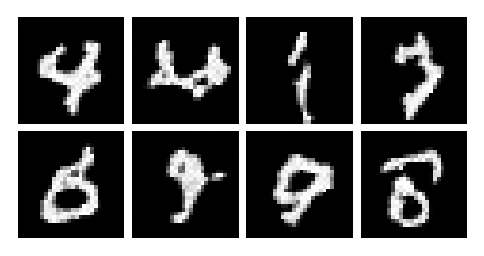

Epoch  11: train NLL/img=-3459.439, val NLL/img=-3389.012, train bpd=-6.3660, val bpd=-6.2364
   train: log_pz=-559.29, ldj=4018.73, log_px=3459.44
   val  : log_pz=-555.25, ldj=3944.26, log_px=3389.01
Epoch  12: train NLL/img=-3475.660, val NLL/img=-3476.280, train bpd=-6.3958, val bpd=-6.3970
   train: log_pz=-558.93, ldj=4034.59, log_px=3475.66
   val  : log_pz=-573.70, ldj=4049.98, log_px=3476.28
   ↳ New best model at epoch 12 (val NLL=-3476.280)
Epoch  13: train NLL/img=-3492.866, val NLL/img=-3492.235, train bpd=-6.4275, val bpd=-6.4263
   train: log_pz=-558.91, ldj=4051.77, log_px=3492.87
   val  : log_pz=-543.89, ldj=4036.12, log_px=3492.23
   ↳ New best model at epoch 13 (val NLL=-3492.235)
Epoch  14: train NLL/img=-3486.020, val NLL/img=-3504.877, train bpd=-6.4149, val bpd=-6.4496
   train: log_pz=-560.92, ldj=4046.94, log_px=3486.02
   val  : log_pz=-556.33, ldj=4061.20, log_px=3504.88
   ↳ New best model at epoch 14 (val NLL=-3504.877)
Epoch  15: train NLL/img=-3509.117, 

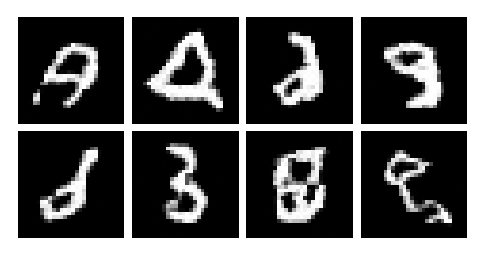

Epoch  21: train NLL/img=-3542.136, val NLL/img=-3521.829, train bpd=-6.5181, val bpd=-6.4808
   train: log_pz=-559.58, ldj=4101.71, log_px=3542.14
   val  : log_pz=-578.32, ldj=4100.15, log_px=3521.83
Epoch  22: train NLL/img=-3553.211, val NLL/img=-3550.021, train bpd=-6.5385, val bpd=-6.5326
   train: log_pz=-559.29, ldj=4112.50, log_px=3553.21
   val  : log_pz=-552.97, ldj=4102.99, log_px=3550.02
Epoch  23: train NLL/img=-3550.633, val NLL/img=-3580.644, train bpd=-6.5338, val bpd=-6.5890
   train: log_pz=-559.16, ldj=4109.80, log_px=3550.63
   val  : log_pz=-545.49, ldj=4126.14, log_px=3580.64
   ↳ New best model at epoch 23 (val NLL=-3580.644)
Epoch  24: train NLL/img=-3553.841, val NLL/img=-3554.518, train bpd=-6.5397, val bpd=-6.5409
   train: log_pz=-559.93, ldj=4113.77, log_px=3553.84
   val  : log_pz=-564.86, ldj=4119.38, log_px=3554.52
Epoch  25: train NLL/img=-3568.478, val NLL/img=-3585.090, train bpd=-6.5666, val bpd=-6.5972
   train: log_pz=-558.37, ldj=4126.85, log_px=

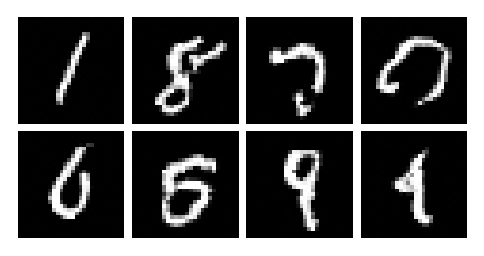

Epoch  31: train NLL/img=-3584.902, val NLL/img=-3563.349, train bpd=-6.5968, val bpd=-6.5572
   train: log_pz=-559.15, ldj=4144.05, log_px=3584.90
   val  : log_pz=-569.21, ldj=4132.56, log_px=3563.35
Epoch  32: train NLL/img=-3581.870, val NLL/img=-3614.472, train bpd=-6.5913, val bpd=-6.6513
   train: log_pz=-558.81, ldj=4140.68, log_px=3581.87
   val  : log_pz=-545.56, ldj=4160.03, log_px=3614.47
   ↳ New best model at epoch 32 (val NLL=-3614.472)
Epoch  33: train NLL/img=-3586.787, val NLL/img=-3582.162, train bpd=-6.6003, val bpd=-6.5918
   train: log_pz=-558.88, ldj=4145.66, log_px=3586.79
   val  : log_pz=-540.93, ldj=4123.10, log_px=3582.16
Epoch  34: train NLL/img=-3585.664, val NLL/img=-3608.821, train bpd=-6.5982, val bpd=-6.6409
   train: log_pz=-559.82, ldj=4145.49, log_px=3585.66
   val  : log_pz=-551.99, ldj=4160.81, log_px=3608.82
Epoch  35: train NLL/img=-3586.771, val NLL/img=-3591.509, train bpd=-6.6003, val bpd=-6.6090
   train: log_pz=-560.15, ldj=4146.92, log_px=

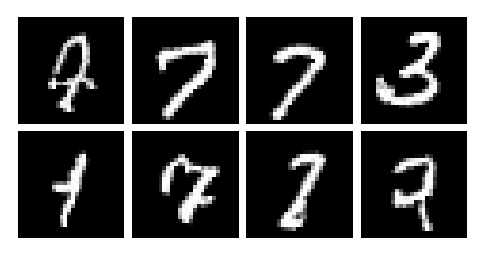

Epoch  41: train NLL/img=-3595.503, val NLL/img=-3610.105, train bpd=-6.6163, val bpd=-6.6432
   train: log_pz=-559.70, ldj=4155.20, log_px=3595.50
   val  : log_pz=-567.00, ldj=4177.11, log_px=3610.10
Epoch  42: train NLL/img=-3604.215, val NLL/img=-3632.699, train bpd=-6.6324, val bpd=-6.6848
   train: log_pz=-560.05, ldj=4164.26, log_px=3604.21
   val  : log_pz=-551.56, ldj=4184.26, log_px=3632.70
   ↳ New best model at epoch 42 (val NLL=-3632.699)
Epoch  43: train NLL/img=-3603.630, val NLL/img=-3634.802, train bpd=-6.6313, val bpd=-6.6887
   train: log_pz=-559.47, ldj=4163.10, log_px=3603.63
   val  : log_pz=-553.28, ldj=4188.08, log_px=3634.80
   ↳ New best model at epoch 43 (val NLL=-3634.802)
Epoch  44: train NLL/img=-3602.585, val NLL/img=-3626.423, train bpd=-6.6294, val bpd=-6.6732
   train: log_pz=-559.77, ldj=4162.36, log_px=3602.58
   val  : log_pz=-573.33, ldj=4199.75, log_px=3626.42
Epoch  45: train NLL/img=-3605.792, val NLL/img=-3610.911, train bpd=-6.6353, val bpd=-6

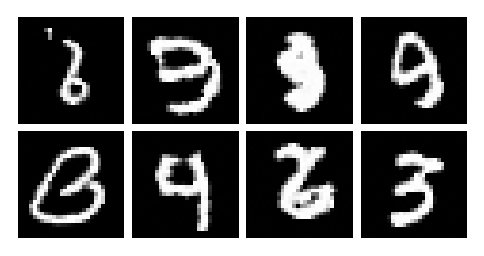

Epoch  51: train NLL/img=-3614.954, val NLL/img=-3627.270, train bpd=-6.6521, val bpd=-6.6748
   train: log_pz=-558.94, ldj=4173.89, log_px=3614.95
   val  : log_pz=-546.79, ldj=4174.06, log_px=3627.27
Epoch  52: train NLL/img=-3621.036, val NLL/img=-3633.798, train bpd=-6.6633, val bpd=-6.6868
   train: log_pz=-558.86, ldj=4179.90, log_px=3621.04
   val  : log_pz=-555.16, ldj=4188.96, log_px=3633.80
Epoch  53: train NLL/img=-3611.385, val NLL/img=-3570.778, train bpd=-6.6456, val bpd=-6.5708
   train: log_pz=-560.82, ldj=4172.20, log_px=3611.38
   val  : log_pz=-540.15, ldj=4110.92, log_px=3570.78
Epoch  54: train NLL/img=-3620.551, val NLL/img=-3641.784, train bpd=-6.6624, val bpd=-6.7015
   train: log_pz=-559.01, ldj=4179.56, log_px=3620.55
   val  : log_pz=-560.02, ldj=4201.81, log_px=3641.78
   ↳ New best model at epoch 54 (val NLL=-3641.784)
Epoch  55: train NLL/img=-3610.926, val NLL/img=-3633.281, train bpd=-6.6447, val bpd=-6.6859
   train: log_pz=-559.66, ldj=4170.58, log_px=

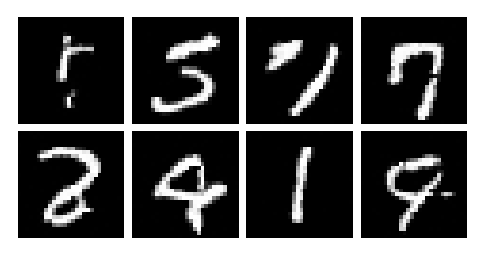

Epoch  61: train NLL/img=-3626.026, val NLL/img=-3629.568, train bpd=-6.6725, val bpd=-6.6790
   train: log_pz=-558.76, ldj=4184.79, log_px=3626.03
   val  : log_pz=-561.10, ldj=4190.67, log_px=3629.57
Epoch  62: train NLL/img=-3629.279, val NLL/img=-3631.312, train bpd=-6.6785, val bpd=-6.6822
   train: log_pz=-559.20, ldj=4188.48, log_px=3629.28
   val  : log_pz=-560.51, ldj=4191.82, log_px=3631.31
Epoch  63: train NLL/img=-3623.897, val NLL/img=-3656.462, train bpd=-6.6686, val bpd=-6.7285
   train: log_pz=-559.85, ldj=4183.74, log_px=3623.90
   val  : log_pz=-555.63, ldj=4212.09, log_px=3656.46
   ↳ New best model at epoch 63 (val NLL=-3656.462)
Epoch  64: train NLL/img=-3619.705, val NLL/img=-3611.566, train bpd=-6.6609, val bpd=-6.6459
   train: log_pz=-559.83, ldj=4179.54, log_px=3619.71
   val  : log_pz=-550.59, ldj=4162.15, log_px=3611.57
Epoch  65: train NLL/img=-3631.406, val NLL/img=-3643.479, train bpd=-6.6824, val bpd=-6.7046
   train: log_pz=-559.16, ldj=4190.56, log_px=

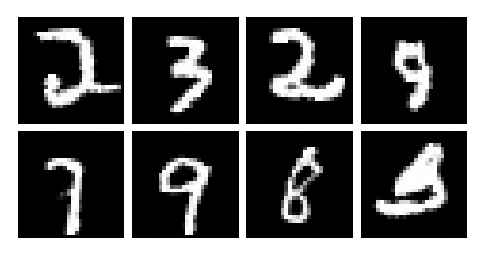

Epoch  71: train NLL/img=-3626.229, val NLL/img=-3635.048, train bpd=-6.6729, val bpd=-6.6891
   train: log_pz=-560.06, ldj=4186.29, log_px=3626.23
   val  : log_pz=-552.33, ldj=4187.37, log_px=3635.05
Epoch  72: train NLL/img=-3633.604, val NLL/img=-3591.029, train bpd=-6.6865, val bpd=-6.6081
   train: log_pz=-560.04, ldj=4193.64, log_px=3633.60
   val  : log_pz=-558.62, ldj=4149.65, log_px=3591.03
Epoch  73: train NLL/img=-3632.191, val NLL/img=-3630.211, train bpd=-6.6839, val bpd=-6.6802
   train: log_pz=-559.44, ldj=4191.63, log_px=3632.19
   val  : log_pz=-572.09, ldj=4202.30, log_px=3630.21
Epoch  74: train NLL/img=-3634.285, val NLL/img=-3626.359, train bpd=-6.6877, val bpd=-6.6731
   train: log_pz=-559.76, ldj=4194.05, log_px=3634.28
   val  : log_pz=-582.84, ldj=4209.20, log_px=3626.36
Epoch  75: train NLL/img=-3628.955, val NLL/img=-3592.311, train bpd=-6.6779, val bpd=-6.6105
   train: log_pz=-559.30, ldj=4188.26, log_px=3628.96
   val  : log_pz=-568.96, ldj=4161.27, log_p

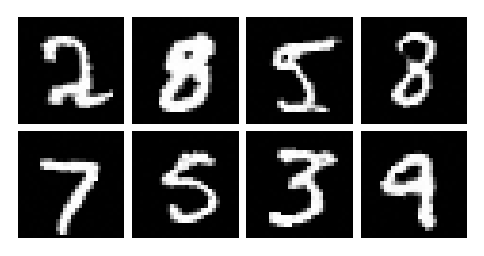

Epoch  81: train NLL/img=-3634.367, val NLL/img=-3656.049, train bpd=-6.6879, val bpd=-6.7278
   train: log_pz=-558.99, ldj=4193.36, log_px=3634.37
   val  : log_pz=-547.43, ldj=4203.47, log_px=3656.05
Epoch  82: train NLL/img=-3635.975, val NLL/img=-3664.209, train bpd=-6.6908, val bpd=-6.7428
   train: log_pz=-560.06, ldj=4196.03, log_px=3635.97
   val  : log_pz=-554.11, ldj=4218.32, log_px=3664.21
   ↳ New best model at epoch 82 (val NLL=-3664.209)
Epoch  83: train NLL/img=-3652.457, val NLL/img=-3668.446, train bpd=-6.7212, val bpd=-6.7506
   train: log_pz=-558.61, ldj=4211.07, log_px=3652.46
   val  : log_pz=-563.60, ldj=4232.05, log_px=3668.45
   ↳ New best model at epoch 83 (val NLL=-3668.446)
Epoch  84: train NLL/img=-3635.518, val NLL/img=-3625.581, train bpd=-6.6900, val bpd=-6.6717
   train: log_pz=-560.51, ldj=4196.03, log_px=3635.52
   val  : log_pz=-559.59, ldj=4185.17, log_px=3625.58
Epoch  85: train NLL/img=-3643.846, val NLL/img=-3639.497, train bpd=-6.7053, val bpd=-6

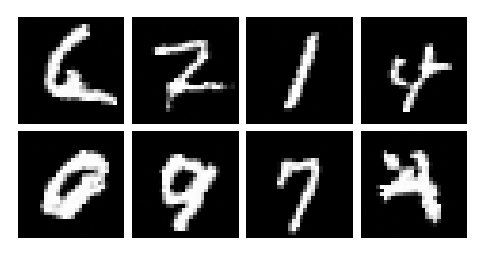

Epoch  91: train NLL/img=-3643.903, val NLL/img=-3620.525, train bpd=-6.7054, val bpd=-6.6624
   train: log_pz=-558.80, ldj=4202.70, log_px=3643.90
   val  : log_pz=-557.83, ldj=4178.36, log_px=3620.53
Epoch  92: train NLL/img=-3647.817, val NLL/img=-3579.493, train bpd=-6.7126, val bpd=-6.5869
   train: log_pz=-559.21, ldj=4207.02, log_px=3647.82
   val  : log_pz=-571.94, ldj=4151.43, log_px=3579.49
Epoch  93: train NLL/img=-3641.574, val NLL/img=-3652.475, train bpd=-6.7011, val bpd=-6.7212
   train: log_pz=-559.67, ldj=4201.24, log_px=3641.57
   val  : log_pz=-553.62, ldj=4206.10, log_px=3652.47
Epoch  94: train NLL/img=-3636.833, val NLL/img=-3669.164, train bpd=-6.6924, val bpd=-6.7519
   train: log_pz=-560.85, ldj=4197.68, log_px=3636.83
   val  : log_pz=-547.83, ldj=4216.99, log_px=3669.16
Epoch  95: train NLL/img=-3640.032, val NLL/img=-3655.436, train bpd=-6.6983, val bpd=-6.7266
   train: log_pz=-560.39, ldj=4200.42, log_px=3640.03
   val  : log_pz=-562.78, ldj=4218.22, log_p

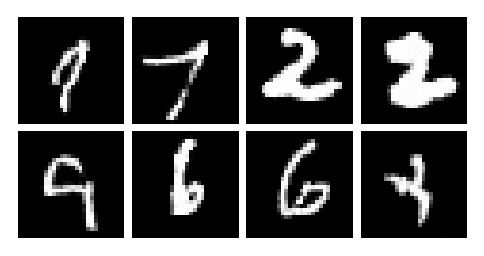


===== Training finished =====
Best epoch: 99
Best val NLL/img: -3676.5299
Best val bpd    : -6.765448
Best val decomposition: log_pz=-561.11, ldj=4237.64, log_px=3676.53


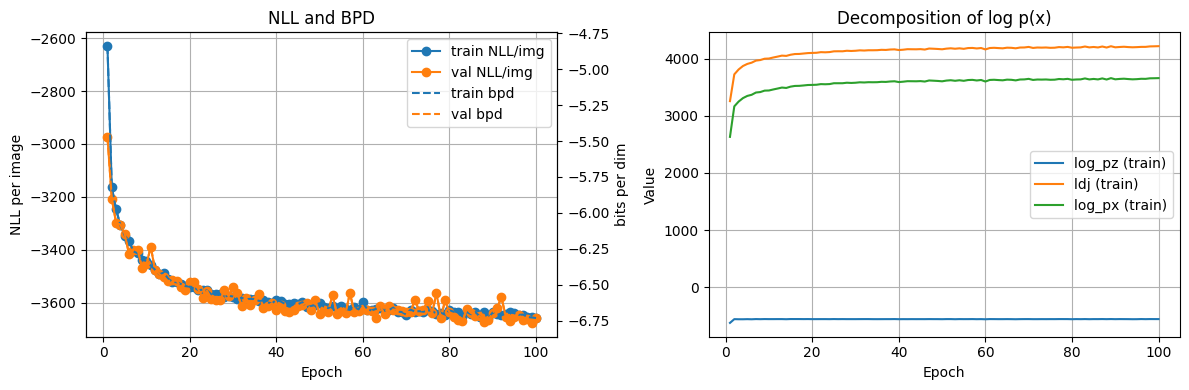

z_all shape: torch.Size([16384, 8, 7, 7])
mean(z_flat) ≈ -0.3886
std(z_flat)  ≈ 0.8976


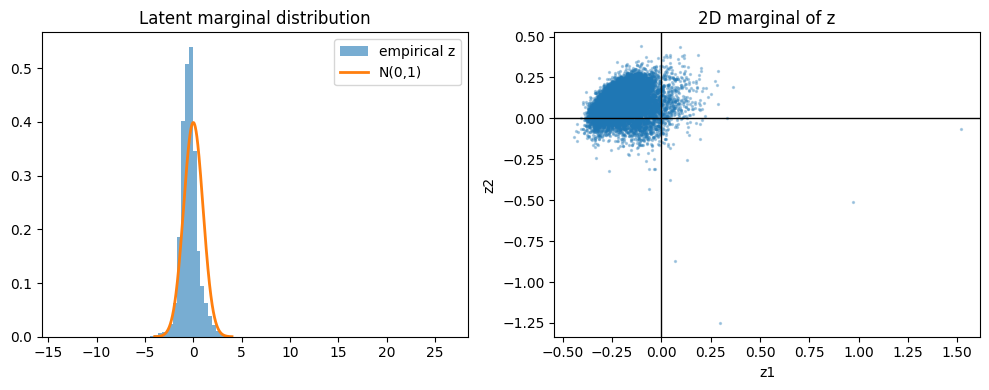

Manual vs model.log_prob:
  max abs diff: 0.0
  mean abs diff: 0.0
Test set:
  NLL/img = -3703.2439
  bpd     = -6.8146
  log_pz  = -552.60
  ldj     = 4255.85
  log_px  = 3703.24


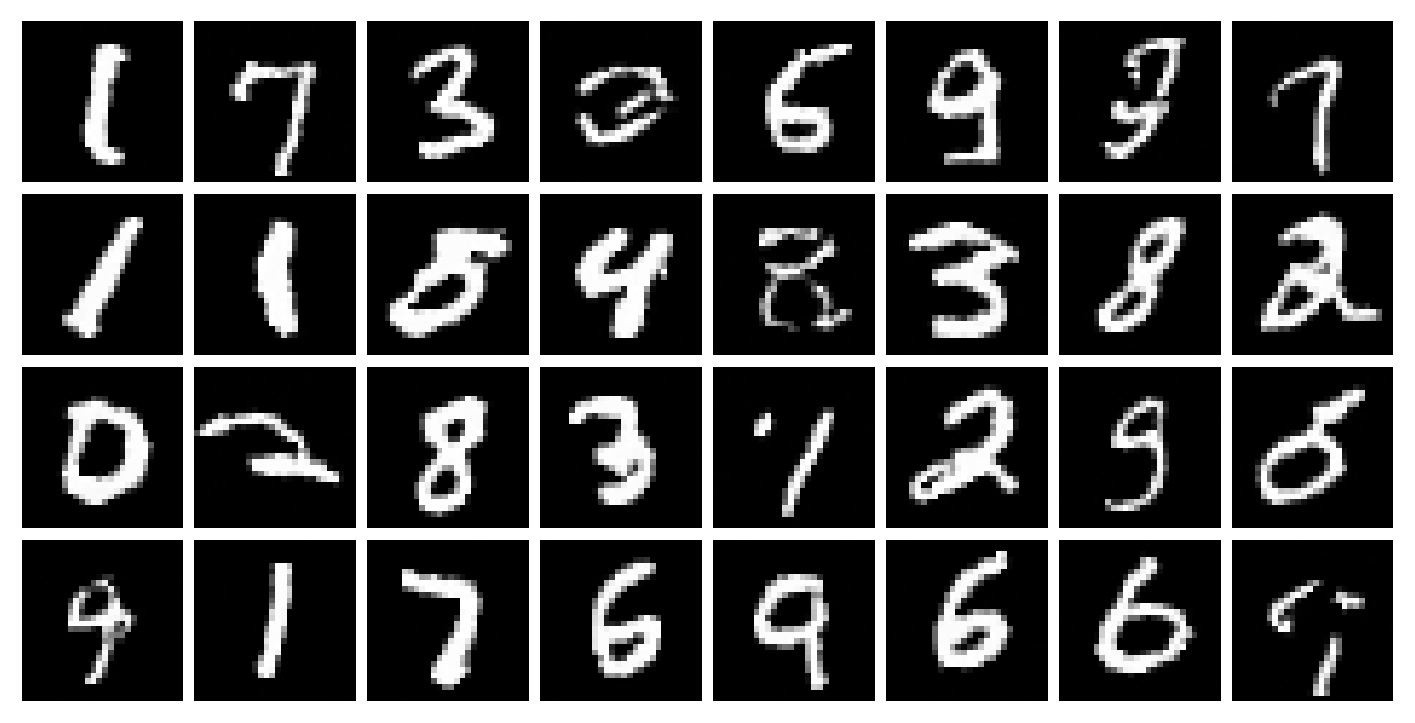

In [ ]:
model = RealNVPMNIST(flows).to(device)
history, best_epoch, best_val = train_realnvp(
    model,
    train_loader=train_digits,
    val_loader=val_digits,
    device=device,
    n_epochs=100,
    lr=5e-4,
    use_dequant=True)

plot_training_history(history)
sanity_check_flow(model, train_digits, device, 128)
evaluate_realnvp(model, test_digits, device)
plot_flow_samples(model, device, n_samples=32)

# MNIST Fashion Test

### GatedConvNet + ActNorm, deeper (4 + 6 + 8 couplings), hidden=32/64/128

In [ ]:
flows = []

# Scale 1: 1×28×28
flows.append(ActNorm2d(1))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))
flows.append(CouplingLayer(c_in=1, hidden=32, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=1, hidden_channels=32)))

# Squeeze: 1×28×28 → 4×14×14
flows.append(SqueezeFlow())

# Scale 2: 4×14×14 (Medium-scale)
flows.append(ActNorm2d(4))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="channelwise", flip=False,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))
flows.append(CouplingLayer(c_in=4, hidden=64, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=4, hidden_channels=64)))

# Split: 4×14×14 → 2×14×14
flows.append(SplitFlow())

# Squeeze: 2×14×14 → 8×7×7
flows.append(SqueezeFlow())

# Scale 3: 8×7×7
flows.append(ActNorm2d(8))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="checkerboard", flip=False,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))
flows.append(CouplingLayer(c_in=8, hidden=128, mask_type="channelwise", flip=True,
                          st_net=GatedSTWrapper(c_in=8, hidden_channels=128)))

Epoch   1: train NLL/img=-541.772, val NLL/img=-2150.933, train bpd=-0.9970, val bpd=-3.9581
   train: log_pz=-1811.12, ldj=2352.89, log_px=541.77
   val  : log_pz=-546.22, ldj=2697.16, log_px=2150.93
   ↳ New best model at epoch 1 (val NLL=-2150.933)
Epoch   2: train NLL/img=-2206.999, val NLL/img=-2288.283, train bpd=-4.0613, val bpd=-4.2108
   train: log_pz=-556.91, ldj=2763.91, log_px=2207.00
   val  : log_pz=-540.75, ldj=2829.03, log_px=2288.28
   ↳ New best model at epoch 2 (val NLL=-2288.283)
Epoch   3: train NLL/img=-2311.939, val NLL/img=-2328.227, train bpd=-4.2544, val bpd=-4.2843
   train: log_pz=-557.77, ldj=2869.71, log_px=2311.94
   val  : log_pz=-548.30, ldj=2876.53, log_px=2328.23
   ↳ New best model at epoch 3 (val NLL=-2328.227)
Epoch   4: train NLL/img=-2385.863, val NLL/img=-2412.483, train bpd=-4.3904, val bpd=-4.4394
   train: log_pz=-557.28, ldj=2943.14, log_px=2385.86
   val  : log_pz=-558.71, ldj=2971.19, log_px=2412.48
   ↳ New best model at epoch 4 (val NLL=

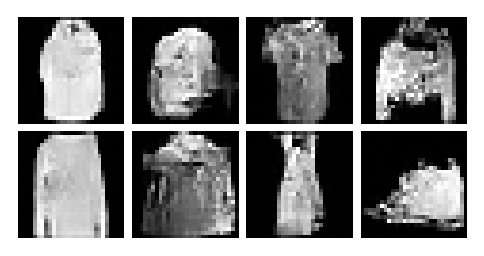

Epoch  11: train NLL/img=-2547.508, val NLL/img=-2546.191, train bpd=-4.6879, val bpd=-4.6854
   train: log_pz=-558.68, ldj=3106.19, log_px=2547.51
   val  : log_pz=-551.17, ldj=3097.37, log_px=2546.19
   ↳ New best model at epoch 11 (val NLL=-2546.191)
Epoch  12: train NLL/img=-2559.126, val NLL/img=-2562.522, train bpd=-4.7092, val bpd=-4.7155
   train: log_pz=-558.49, ldj=3117.61, log_px=2559.13
   val  : log_pz=-561.25, ldj=3123.77, log_px=2562.52
   ↳ New best model at epoch 12 (val NLL=-2562.522)
Epoch  13: train NLL/img=-2571.556, val NLL/img=-2571.461, train bpd=-4.7321, val bpd=-4.7319
   train: log_pz=-558.19, ldj=3129.74, log_px=2571.56
   val  : log_pz=-550.30, ldj=3121.76, log_px=2571.46
   ↳ New best model at epoch 13 (val NLL=-2571.461)
Epoch  14: train NLL/img=-2578.221, val NLL/img=-2595.610, train bpd=-4.7444, val bpd=-4.7764
   train: log_pz=-558.17, ldj=3136.39, log_px=2578.22
   val  : log_pz=-560.00, ldj=3155.61, log_px=2595.61
   ↳ New best model at epoch 14 (val

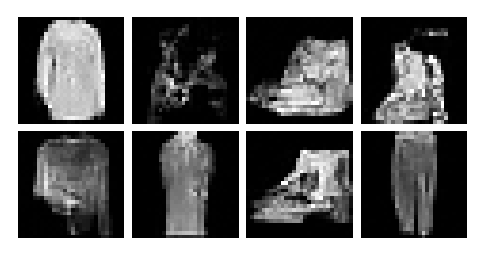

Epoch  21: train NLL/img=-2629.311, val NLL/img=-2620.869, train bpd=-4.8384, val bpd=-4.8229
   train: log_pz=-557.88, ldj=3187.19, log_px=2629.31
   val  : log_pz=-572.61, ldj=3193.48, log_px=2620.87
Epoch  22: train NLL/img=-2631.851, val NLL/img=-2624.494, train bpd=-4.8431, val bpd=-4.8295
   train: log_pz=-557.98, ldj=3189.83, log_px=2631.85
   val  : log_pz=-561.80, ldj=3186.30, log_px=2624.49
Epoch  23: train NLL/img=-2638.935, val NLL/img=-2633.036, train bpd=-4.8561, val bpd=-4.8452
   train: log_pz=-557.84, ldj=3196.78, log_px=2638.94
   val  : log_pz=-557.09, ldj=3190.13, log_px=2633.04
Epoch  24: train NLL/img=-2642.445, val NLL/img=-2646.335, train bpd=-4.8626, val bpd=-4.8697
   train: log_pz=-557.76, ldj=3200.21, log_px=2642.44
   val  : log_pz=-557.59, ldj=3203.93, log_px=2646.34
   ↳ New best model at epoch 24 (val NLL=-2646.335)
Epoch  25: train NLL/img=-2645.736, val NLL/img=-2611.613, train bpd=-4.8686, val bpd=-4.8058
   train: log_pz=-557.83, ldj=3203.56, log_px=

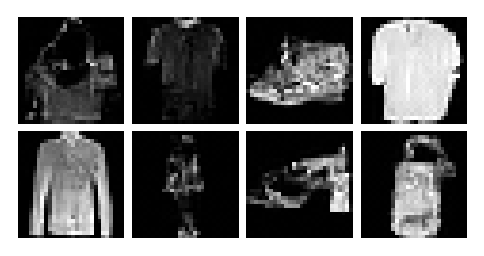

Epoch  31: train NLL/img=-2660.034, val NLL/img=-2649.682, train bpd=-4.8949, val bpd=-4.8759
   train: log_pz=-557.47, ldj=3217.51, log_px=2660.03
   val  : log_pz=-560.72, ldj=3210.40, log_px=2649.68
Epoch  32: train NLL/img=-2670.670, val NLL/img=-2661.314, train bpd=-4.9145, val bpd=-4.8973
   train: log_pz=-557.57, ldj=3228.24, log_px=2670.67
   val  : log_pz=-569.65, ldj=3230.96, log_px=2661.31
   ↳ New best model at epoch 32 (val NLL=-2661.314)
Epoch  33: train NLL/img=-2671.108, val NLL/img=-2639.576, train bpd=-4.9153, val bpd=-4.8573
   train: log_pz=-557.59, ldj=3228.70, log_px=2671.11
   val  : log_pz=-586.27, ldj=3225.85, log_px=2639.58
Epoch  34: train NLL/img=-2678.370, val NLL/img=-2653.082, train bpd=-4.9287, val bpd=-4.8821
   train: log_pz=-557.44, ldj=3235.81, log_px=2678.37
   val  : log_pz=-565.16, ldj=3218.24, log_px=2653.08
Epoch  35: train NLL/img=-2680.326, val NLL/img=-2650.753, train bpd=-4.9323, val bpd=-4.8778
   train: log_pz=-557.43, ldj=3237.76, log_px=

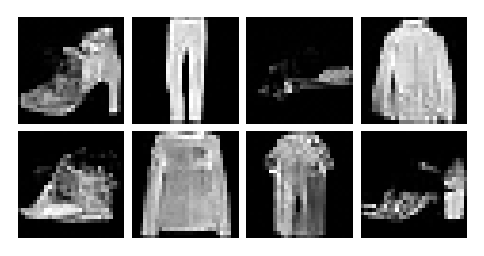

Epoch  41: train NLL/img=-2692.887, val NLL/img=-2655.173, train bpd=-4.9554, val bpd=-4.8860
   train: log_pz=-557.45, ldj=3250.34, log_px=2692.89
   val  : log_pz=-571.10, ldj=3226.27, log_px=2655.17
Epoch  42: train NLL/img=-2692.874, val NLL/img=-2654.336, train bpd=-4.9554, val bpd=-4.8844
   train: log_pz=-557.24, ldj=3250.11, log_px=2692.87
   val  : log_pz=-575.46, ldj=3229.79, log_px=2654.34
Epoch  43: train NLL/img=-2691.991, val NLL/img=-2644.936, train bpd=-4.9537, val bpd=-4.8671
   train: log_pz=-557.62, ldj=3249.61, log_px=2691.99
   val  : log_pz=-576.16, ldj=3221.09, log_px=2644.94
Epoch  44: train NLL/img=-2695.275, val NLL/img=-2666.730, train bpd=-4.9598, val bpd=-4.9072
   train: log_pz=-557.30, ldj=3252.57, log_px=2695.28
   val  : log_pz=-586.48, ldj=3253.21, log_px=2666.73
   ↳ New best model at epoch 44 (val NLL=-2666.730)
Epoch  45: train NLL/img=-2697.559, val NLL/img=-2656.353, train bpd=-4.9640, val bpd=-4.8881
   train: log_pz=-557.51, ldj=3255.07, log_px=

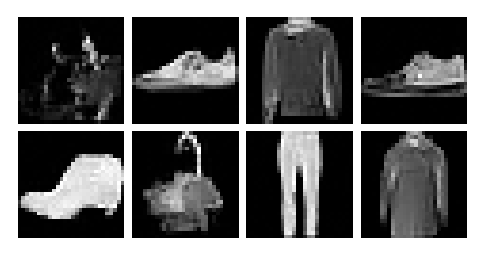

Epoch  51: train NLL/img=-2710.497, val NLL/img=-2667.579, train bpd=-4.9878, val bpd=-4.9088
   train: log_pz=-557.60, ldj=3268.10, log_px=2710.50
   val  : log_pz=-581.61, ldj=3249.19, log_px=2667.58
Epoch  52: train NLL/img=-2715.194, val NLL/img=-2686.768, train bpd=-4.9964, val bpd=-4.9441
   train: log_pz=-557.22, ldj=3272.42, log_px=2715.19
   val  : log_pz=-580.33, ldj=3267.10, log_px=2686.77
   ↳ New best model at epoch 52 (val NLL=-2686.768)
Epoch  53: train NLL/img=-2712.503, val NLL/img=-2679.057, train bpd=-4.9915, val bpd=-4.9299
   train: log_pz=-557.46, ldj=3269.97, log_px=2712.50
   val  : log_pz=-583.67, ldj=3262.72, log_px=2679.06
Epoch  54: train NLL/img=-2712.462, val NLL/img=-2649.683, train bpd=-4.9914, val bpd=-4.8759
   train: log_pz=-557.57, ldj=3270.04, log_px=2712.46
   val  : log_pz=-599.87, ldj=3249.56, log_px=2649.68
Epoch  55: train NLL/img=-2716.288, val NLL/img=-2650.269, train bpd=-4.9984, val bpd=-4.8770
   train: log_pz=-557.46, ldj=3273.75, log_px=

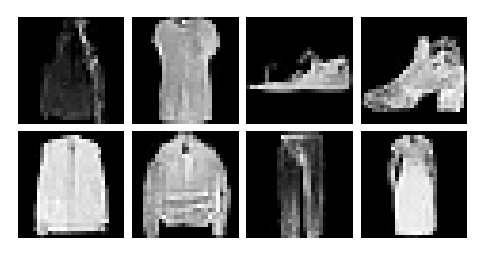

Epoch  61: train NLL/img=-2726.005, val NLL/img=-2658.863, train bpd=-5.0163, val bpd=-4.8928
   train: log_pz=-557.14, ldj=3283.15, log_px=2726.00
   val  : log_pz=-592.23, ldj=3251.09, log_px=2658.86
Epoch  62: train NLL/img=-2724.066, val NLL/img=-2679.409, train bpd=-5.0128, val bpd=-4.9306
   train: log_pz=-557.59, ldj=3281.66, log_px=2724.07
   val  : log_pz=-588.20, ldj=3267.60, log_px=2679.41
Epoch  63: train NLL/img=-2725.600, val NLL/img=-2672.986, train bpd=-5.0156, val bpd=-4.9188
   train: log_pz=-557.22, ldj=3282.82, log_px=2725.60
   val  : log_pz=-585.78, ldj=3258.77, log_px=2672.99
Epoch  64: train NLL/img=-2723.860, val NLL/img=-2681.136, train bpd=-5.0124, val bpd=-4.9338
   train: log_pz=-557.49, ldj=3281.35, log_px=2723.86
   val  : log_pz=-594.56, ldj=3275.69, log_px=2681.14
Epoch  65: train NLL/img=-2727.341, val NLL/img=-2680.963, train bpd=-5.0188, val bpd=-4.9334
   train: log_pz=-557.31, ldj=3284.65, log_px=2727.34
   val  : log_pz=-588.25, ldj=3269.22, log_p

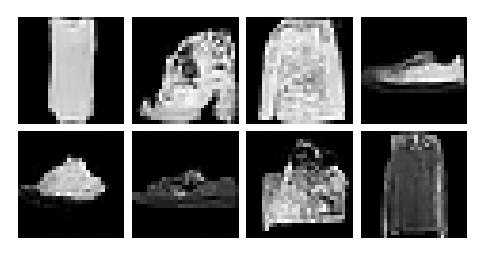

Epoch  71: train NLL/img=-2743.032, val NLL/img=-2686.461, train bpd=-5.0477, val bpd=-4.9436
   train: log_pz=-556.72, ldj=3299.75, log_px=2743.03
   val  : log_pz=-596.16, ldj=3282.62, log_px=2686.46
Epoch  72: train NLL/img=-2734.355, val NLL/img=-2667.463, train bpd=-5.0317, val bpd=-4.9086
   train: log_pz=-557.35, ldj=3291.70, log_px=2734.36
   val  : log_pz=-585.88, ldj=3253.34, log_px=2667.46
Epoch  73: train NLL/img=-2735.944, val NLL/img=-2688.808, train bpd=-5.0346, val bpd=-4.9479
   train: log_pz=-557.68, ldj=3293.63, log_px=2735.94
   val  : log_pz=-581.86, ldj=3270.66, log_px=2688.81
Epoch  74: train NLL/img=-2735.241, val NLL/img=-2677.680, train bpd=-5.0333, val bpd=-4.9274
   train: log_pz=-557.44, ldj=3292.68, log_px=2735.24
   val  : log_pz=-580.24, ldj=3257.92, log_px=2677.68
Epoch  75: train NLL/img=-2734.224, val NLL/img=-2688.799, train bpd=-5.0314, val bpd=-4.9479
   train: log_pz=-557.50, ldj=3291.73, log_px=2734.22
   val  : log_pz=-598.76, ldj=3287.56, log_p

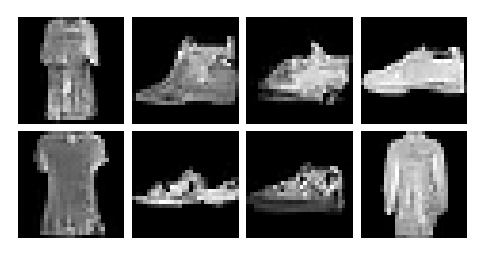

Epoch  81: train NLL/img=-2738.038, val NLL/img=-2688.492, train bpd=-5.0385, val bpd=-4.9473
   train: log_pz=-557.49, ldj=3295.53, log_px=2738.04
   val  : log_pz=-606.23, ldj=3294.72, log_px=2688.49
Epoch  82: train NLL/img=-2748.707, val NLL/img=-2691.013, train bpd=-5.0581, val bpd=-4.9519
   train: log_pz=-557.00, ldj=3305.71, log_px=2748.71
   val  : log_pz=-602.12, ldj=3293.13, log_px=2691.01
Epoch  83: train NLL/img=-2742.433, val NLL/img=-2677.433, train bpd=-5.0465, val bpd=-4.9269
   train: log_pz=-557.87, ldj=3300.30, log_px=2742.43
   val  : log_pz=-600.73, ldj=3278.16, log_px=2677.43
Epoch  84: train NLL/img=-2745.828, val NLL/img=-2665.982, train bpd=-5.0528, val bpd=-4.9059
   train: log_pz=-557.76, ldj=3303.59, log_px=2745.83
   val  : log_pz=-596.19, ldj=3262.17, log_px=2665.98
Epoch  85: train NLL/img=-2745.803, val NLL/img=-2674.753, train bpd=-5.0527, val bpd=-4.9220
   train: log_pz=-557.56, ldj=3303.36, log_px=2745.80
   val  : log_pz=-597.64, ldj=3272.39, log_p

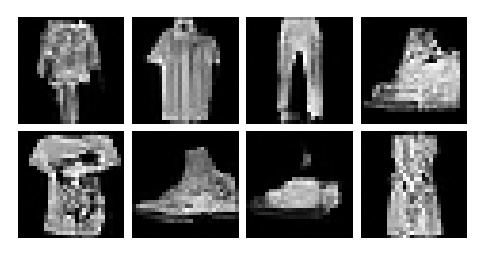

Epoch  91: train NLL/img=-2751.557, val NLL/img=-2634.451, train bpd=-5.0633, val bpd=-4.8478
   train: log_pz=-557.65, ldj=3309.21, log_px=2751.56
   val  : log_pz=-586.63, ldj=3221.08, log_px=2634.45
Epoch  92: train NLL/img=-2745.330, val NLL/img=-2697.497, train bpd=-5.0519, val bpd=-4.9639
   train: log_pz=-557.50, ldj=3302.83, log_px=2745.33
   val  : log_pz=-595.77, ldj=3293.27, log_px=2697.50
   ↳ New best model at epoch 92 (val NLL=-2697.497)
Epoch  93: train NLL/img=-2755.499, val NLL/img=-2671.854, train bpd=-5.0706, val bpd=-4.9167
   train: log_pz=-557.00, ldj=3312.50, log_px=2755.50
   val  : log_pz=-590.10, ldj=3261.96, log_px=2671.85
Epoch  94: train NLL/img=-2751.469, val NLL/img=-2689.448, train bpd=-5.0632, val bpd=-4.9490
   train: log_pz=-557.51, ldj=3308.98, log_px=2751.47
   val  : log_pz=-600.96, ldj=3290.40, log_px=2689.45
Epoch  95: train NLL/img=-2753.382, val NLL/img=-2683.833, train bpd=-5.0667, val bpd=-4.9387
   train: log_pz=-557.29, ldj=3310.67, log_px=

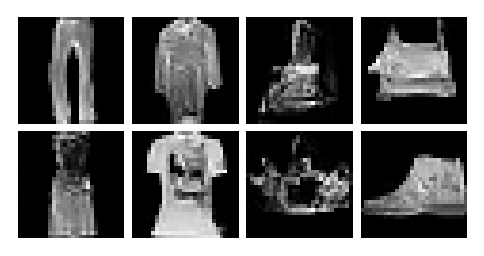


===== Training finished =====
Best epoch: 92
Best val NLL/img: -2697.4968
Best val bpd    : -4.963859
Best val decomposition: log_pz=-595.77, ldj=3293.27, log_px=2697.50


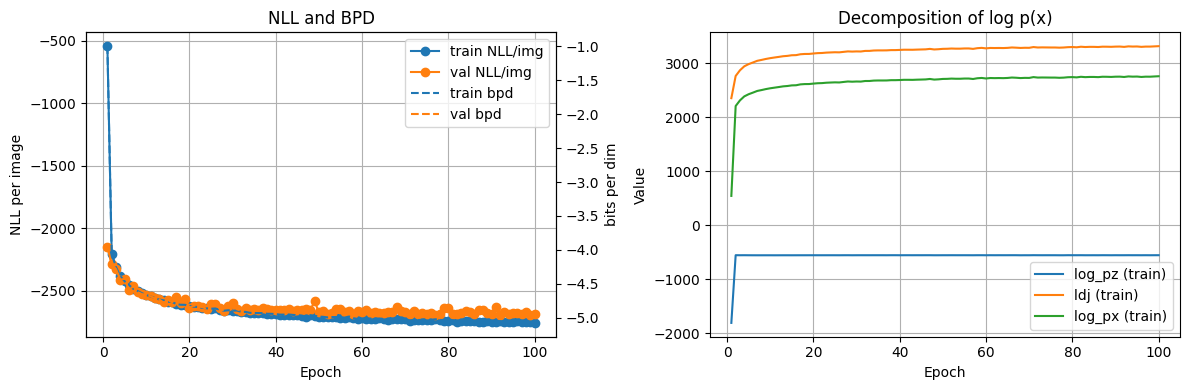

z_all shape: torch.Size([16384, 8, 7, 7])
mean(z_flat) ≈ -0.1450
std(z_flat)  ≈ 0.8717


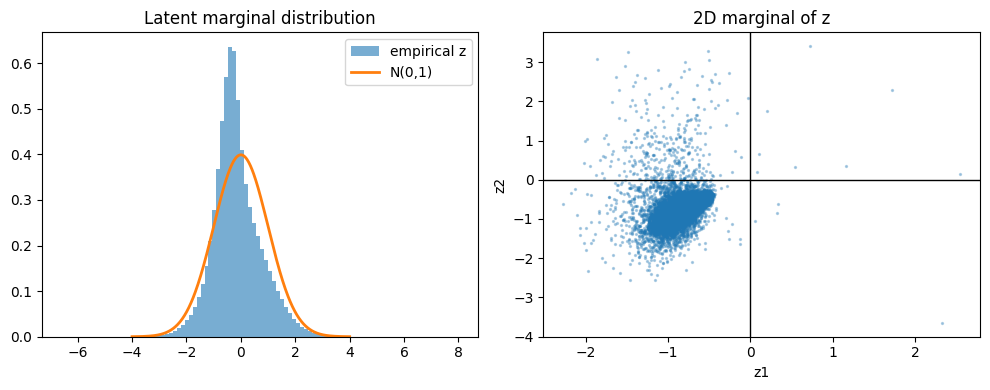

Manual vs model.log_prob:
  max abs diff: 0.0
  mean abs diff: 0.0
Test set:
  NLL/img = -2776.6255
  bpd     = -5.1095
  log_pz  = -564.95
  ldj     = 3341.57
  log_px  = 2776.63


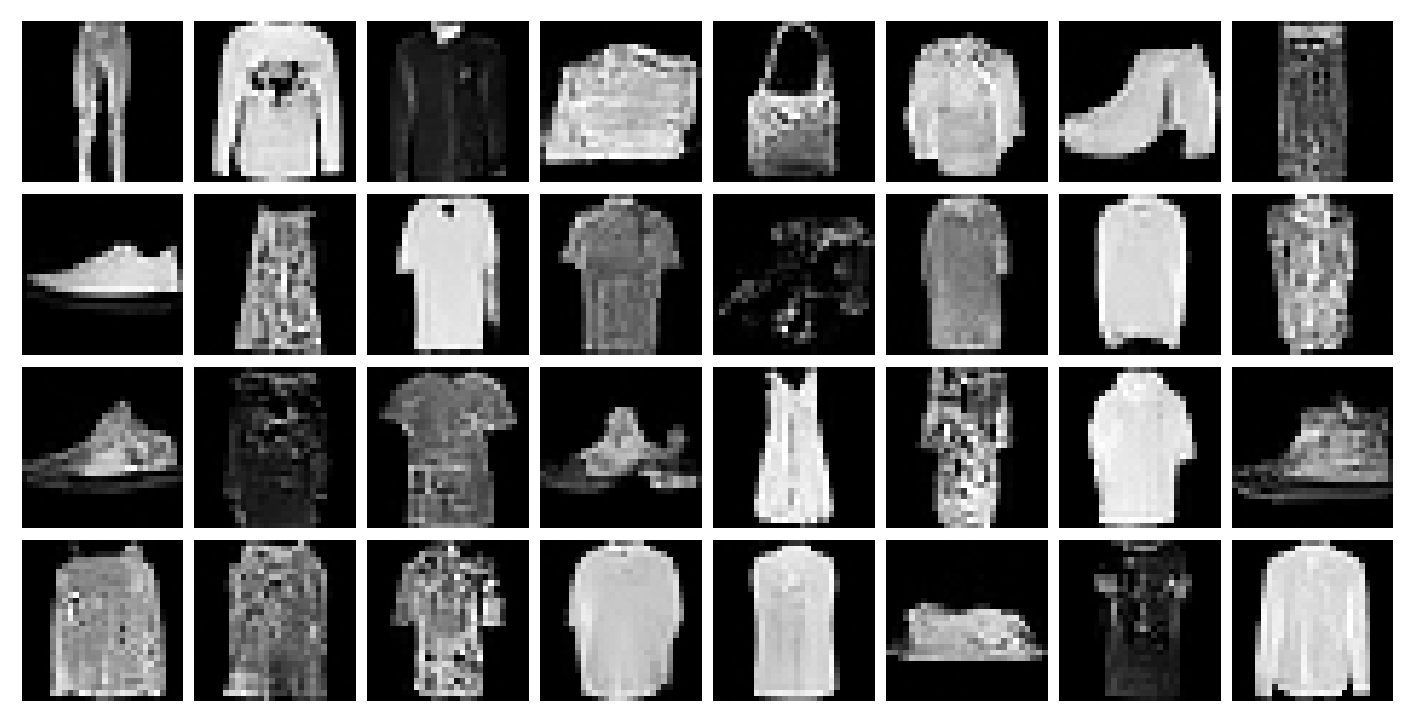

In [ ]:
model = RealNVPMNIST(flows).to(device)
history, best_epoch, best_val = train_realnvp(
    model,
    train_loader=train_fashion,
    val_loader=val_fashion,
    device=device,
    n_epochs=100,
    lr=5e-4,
    use_dequant=True)

plot_training_history(history)
sanity_check_flow(model, train_fashion, device, 128)
evaluate_realnvp(model, test_fashion, device)
plot_flow_samples(model, device, n_samples=32)

# Disappointing Doubles

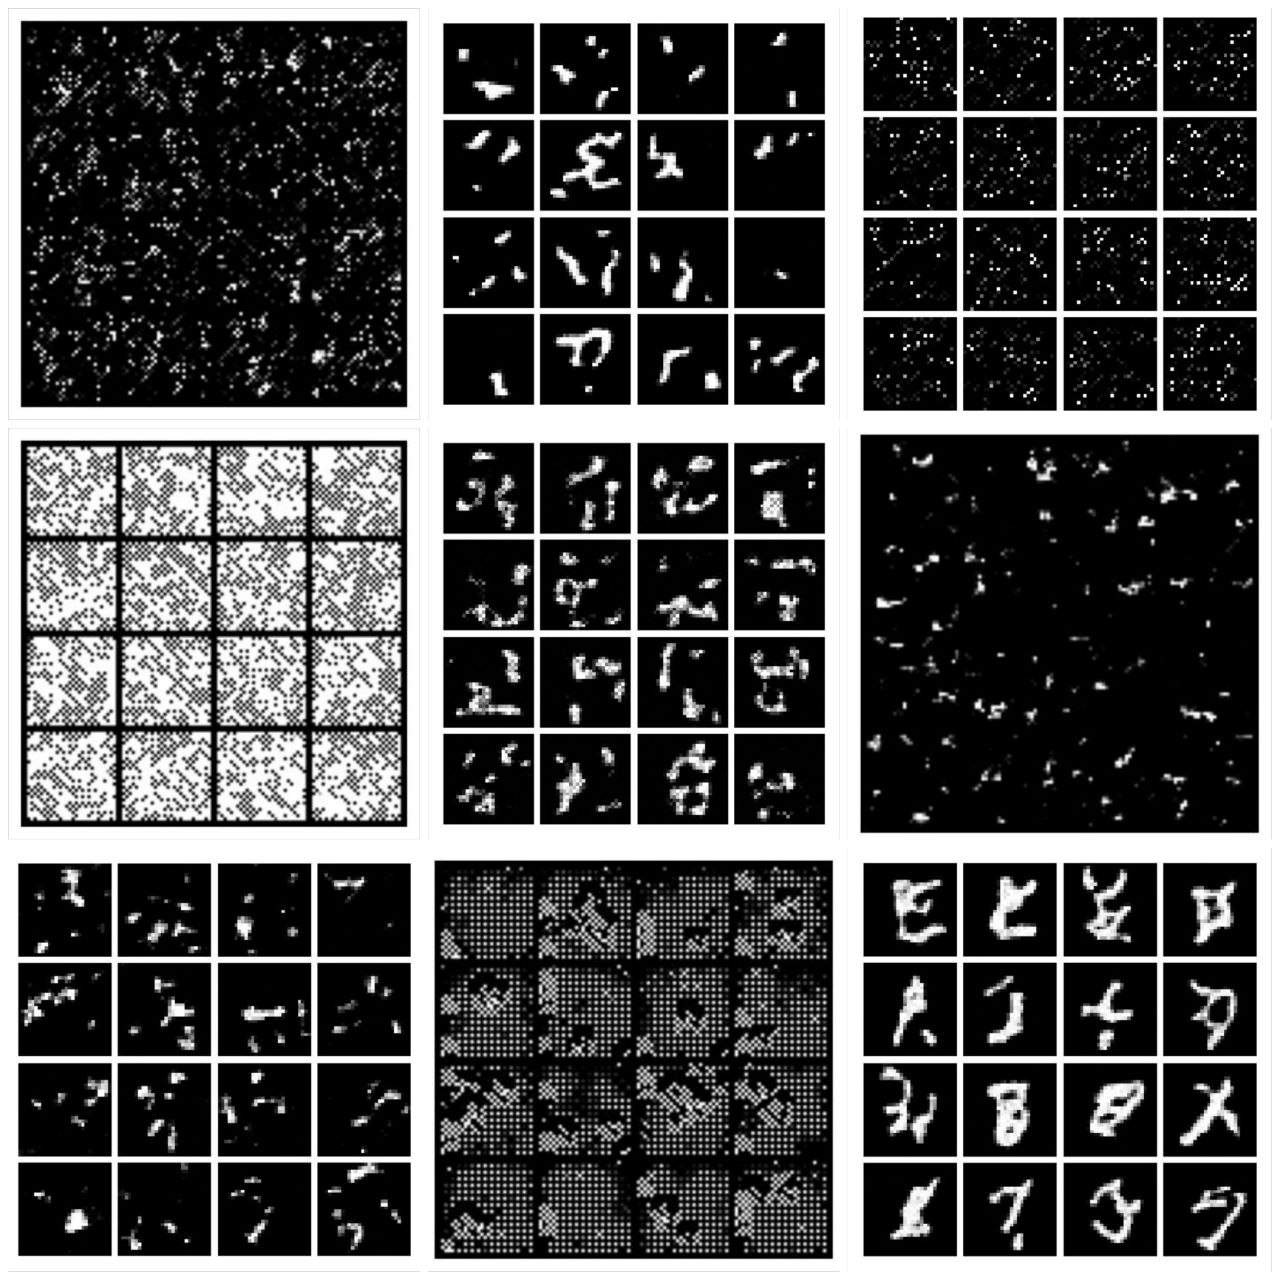